## PHẦN 1: CÀI ĐẶT, IMPORTS & THIẾT LẬP BAN ĐẦU

In [20]:
# ==============================================================================
# CELL 1.1: CÀI ĐẶT THƯ VIỆN & BIẾN MÔI TRƯỜNG (CẬP NHẬT)
# ==============================================================================
import os
import json
import asyncio
import operator
import time 
import re
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union

# Tải các biến môi trường
from dotenv import load_dotenv 
load_dotenv()

# LangChain & LangGraph
from langchain_core.messages import BaseMessage, HumanMessage   
from pydantic.v1 import BaseModel, Field, schema_json_of

from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

# --- NÂNG CẤP: Thêm công cụ tìm kiếm ---
from langchain_community.tools.tavily_search import TavilySearchResults

# Thư viện hỗ trợ & Kho tri thức
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from rich.console import Console
from rich.markdown import Markdown
from rich.pretty import pprint
from IPython.display import Image, display

In [21]:
# ==============================================================================
# CELL 1.2: CẤU HÌNH LOG & CÁC HÀM IN ẤN
# ==============================================================================
from langchain_groq import ChatGroq
from markdown_pdf import MarkdownPdf, Section
# --- CẤU HÌNH LOG ---
VERBOSE_MODE = True

# --- KHỞI TẠO CÁC CÔNG CỤ IN ẤN ---
console = Console()

def print_step(message: str):
    if VERBOSE_MODE:
        console.print(f"\n[bold cyan]>[/bold cyan] {message}")

def print_result(data: Any, title: str = "Kết quả"):
    if VERBOSE_MODE:
        console.print(f"[bold green]✔️ {title}:[/bold green]")
        pprint(data, expand_all=True)
        
def print_warning(message: str):
    if VERBOSE_MODE:
        console.print(f"[bold yellow]⚠️  {message}[/bold yellow]")

async def save_markdown_to_pdf(markdown_content: str, output_filename: str = "GiaoAn.pdf"):
    """
    Chuyển đổi một chuỗi Markdown thành file PDF và lưu lại.
    """
    print_step(f"Đang chuyển đổi giáo án sang file PDF: '{output_filename}'...")
    try:
        pdf = MarkdownPdf(toc_level=2) 
        
        # Thêm nội dung Markdown vào PDF
        pdf.add_section(Section(markdown_content, toc=True))
        
        # Lưu file PDF
        pdf.save(output_filename)
        
        print(f"✅ Đã lưu giáo án thành công vào file '{output_filename}'")
    except Exception as e:
        print_warning(f"Lỗi khi tạo file PDF: {e}")
        print_warning("Có thể bạn chưa cài đặt markdown-pdf hoặc các dependency của nó. Hãy thử chạy 'pip install markdown-pdf' trong terminal.")



In [22]:
# ==============================================================================
# CELL 1.3: KHỞI TẠO LLM (NÂNG CẤP SANG GOOGLE AI STUDIO)
# ==============================================================================
try:
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.5-flash", # Sử dụng model mới nhất và mạnh nhất
        temperature=0.1,
        google_api_key=os.getenv("GOOGLE_API_KEY")
    )
    print("✅ LLM (Gemini 2.5 Flash từ Google AI Studio) đã được khởi tạo thành công.")
except Exception as e:
    print(f"❌ LỖI: Không thể khởi tạo LLM. Hãy chắc chắn bạn đã cài 'langchain-google-genai' và có GOOGLE_API_KEY trong file .env. Lỗi: {e}")
    llm = None

✅ LLM (Gemini 2.5 Flash từ Google AI Studio) đã được khởi tạo thành công.


In [23]:
# ==============================================================================
# CELL 1.4: TẢI KHO TRI THỨC (RAG)
# ==============================================================================
# --- TẢI KHO TRI THỨC ---
BASE_VECTOR_STORE_PATH = "vector_store"
vector_store = None
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

if os.path.exists(BASE_VECTOR_STORE_PATH):
    subdirectories = [f.path for f in os.scandir(BASE_VECTOR_STORE_PATH) if f.is_dir()]
    if not subdirectories:
        print(f"❌ LỖI: Không tìm thấy thư mục con nào trong '{BASE_VECTOR_STORE_PATH}'.")
    else:
        try:
            print_step(f"Đang tải và hợp nhất các kho tri thức từ {len(subdirectories)} thư mục...")
            # Tải kho tri thức đầu tiên để làm cơ sở
            first_store_path = subdirectories.pop(0)
            vector_store = FAISS.load_local(first_store_path, embeddings, allow_dangerous_deserialization=True)
            print(f"✅ Đã tải thành công kho tri thức cơ sở: '{os.path.basename(first_store_path)}'")

            # Hợp nhất các kho tri thức còn lại
            for store_path in subdirectories:
                if os.path.exists(os.path.join(store_path, "index.faiss")):
                    temp_store = FAISS.load_local(store_path, embeddings, allow_dangerous_deserialization=True)
                    vector_store.merge_from(temp_store)
                    print(f"✅ Đã hợp nhất thành công: '{os.path.basename(store_path)}'")
                else:
                    print_warning(f"Bỏ qua thư mục '{os.path.basename(store_path)}' vì không chứa file index.faiss.")
            
            print("\n[bold green]✔️ Tất cả các kho tri thức RAG đã được tải và hợp nhất thành công.[/bold green]")

        except Exception as e:
            print(f"❌ LỖI trong quá trình tải hoặc hợp nhất kho tri thức: {e}")
else:
    print(f"❌ LỖI: Không tìm thấy thư mục gốc của kho tri thức tại '{BASE_VECTOR_STORE_PATH}'.")


> Đang tải và hợp nhất các kho tri thức từ 3 thư mục...

✅ Đã tải thành công kho tri thức cơ sở: 'sgk_toan_12_1'
✅ Đã hợp nhất thành công: 'sgk_toan_12_2'
✅ Đã hợp nhất thành công: 'sgk_toan_9_1'

[bold green]✔️ Tất cả các kho tri thức RAG đã được tải và hợp nhất thành công.[/bold green]


In [24]:
# ==============================================================================
# CELL 1.5: KHỞI TẠO VÀ QUẢN LÝ TRÍ NHỚ DÀI HẠN (NÂNG CẤP V9.4)
# ==============================================================================
MEMORY_FILE_PATH = "long_term_memory.json"
memory_vector_store = None

# Hàm để tải trí nhớ từ file JSON
def load_memory():
    if not os.path.exists(MEMORY_FILE_PATH):
        return []
    with open(MEMORY_FILE_PATH, 'r', encoding='utf-8') as f:
        return json.load(f)

# Hàm để lưu một giáo án mới vào trí nhớ
def save_to_memory(request: str, structured_plan: Dict[str, Any]):
    memory = load_memory()
    memory.append({
        "request": request,
        "plan": structured_plan
    })
    with open(MEMORY_FILE_PATH, 'w', encoding='utf-8') as f:
        json.dump(memory, f, ensure_ascii=False, indent=2)
    print_step("🧠 Đã lưu giáo án thành công vào Trí nhớ Dài hạn.")

# Hàm để tạo một vector store từ trí nhớ (để tìm kiếm tương đồng)
def build_memory_vector_store():
    global memory_vector_store
    memory_content = load_memory()
    if not memory_content:
        print_warning("Trí nhớ trống, không có gì để xây dựng vector store.")
        return

    # Chỉ lấy phần 'request' để tìm kiếm
    texts = [item['request'] for item in memory_content]
    # Lưu toàn bộ item làm metadata
    metadatas = memory_content
    
    memory_vector_store = FAISS.from_texts(texts, embeddings, metadatas=metadatas)
    print_step("✅ Đã xây dựng Vector Store cho Trí nhớ Dài hạn.")

# Tự động xây dựng vector store khi khởi động notebook
build_memory_vector_store()

> ✅ Đã xây dựng Vector Store cho Trí nhớ Dài hạn.

## PHẦN 2: ĐỊNH NGHĨA STATE CỦA HỆ THỐNG

In [25]:
# ==============================================================================
# CELL 2.1: ĐỊNH NGHĨA STATE NÂNG CAO (v9.0)
# ==============================================================================
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
import operator

# --- Hàm tiện ích (giữ nguyên) ---
def merge_dicts(dict1: Dict[str, Any], dict2: Dict[str, Any]) -> Dict[str, Any]:
    merged = dict1.copy()
    for key, value in dict2.items():
        if key in merged and isinstance(merged[key], dict) and isinstance(value, dict):
            merged[key] = merge_dicts(merged[key], value)
        else:
            merged[key] = value
    return merged

# --- Cấu trúc dữ liệu con (giữ nguyên) ---
class DetailedTask(TypedDict):
    task_id: int
    task_name: str
    task_description: str
    estimated_duration: int 
    guidance: str
    status: Literal["pending", "completed"]

# === NÂNG CẤP V9.0: CÁC CẤU TRÚC DỮ LIỆU MỚI CHO TƯ DUY SÂU ===
class DifferentiatedInstruction(TypedDict):
    """Gợi ý cho việc dạy học phân hóa trong một hoạt động."""
    for_struggling_students: str
    for_advanced_students: str

class StructuredContentItem(TypedDict):
    """Định nghĩa một hoạt động hoặc đánh giá có cấu trúc."""
    task_id: int
    activity_name: str
    question_or_description: str # Gộp 'question' và 'description'
    duration_minutes: int
    content_type: str # Gộp 'activity_type' và 'question_type'
    teacher_actions: List[str]
    solution_guide: Any
    answer: Optional[str] # Dành cho câu hỏi đánh giá
    differentiation: Optional[DifferentiatedInstruction]

class FinalStructuredPlan(TypedDict):
    """Định nghĩa cấu trúc JSON cho giáo án cuối cùng."""
    general_info: Dict[str, Any]
    learning_objectives: List[str]
    preparation: Dict[str, List[str]]
    knowledge_summary: str
    lesson_flow: List[StructuredContentItem]
    # pedagogical_explainer: Dict[str, Any] # Dành cho nâng cấp tương lai


class TeacherStateV5(TypedDict):
    # Các trường cơ bản
    original_request: str
    messages: Annotated[List[BaseMessage], add_messages]
    domain: Optional[str]
    
    # student_persona giờ sẽ chứa cả chiến lược phân hóa ===
    student_persona: Optional[Dict[str, Any]] 
    
    # Các bước tuần tự ban đầu
    analyzed_objective: Optional[Any]
    pedagogy_strategy: Optional[Any]
    pedagogical_blueprint: Optional[List[str]]

    # Các trường nâng cao
    expanded_queries: Optional[List[str]]
    task_list: Optional[List[DetailedTask]]
    current_task_id: Optional[int]
    current_task_retry_count: int 
    reflection_notes: Optional[str]
    agent_outputs: Annotated[Dict[str, Any], merge_dicts] 
    next_agent: str
    
    # Các trường tạm thời cho vòng lặp kiểm duyệt vi mô (Micro-loop)
    current_content_to_validate: Optional[Dict[str, Any]]
    validation_feedback: Optional[str]

    inspirational_example: Optional[List[Dict[str, Any]]]

    # Output cuối cùng sẽ có 2 dạng 
    final_structured_plan: Optional[FinalStructuredPlan] # Dạng JSON có cấu trúc
    final_markdown_plan: Optional[str] # Dạng Markdown để hiển thị


print("✅ 'TeacherStateV5' (v9.0 - Hỗ trợ Phân hóa & Cấu trúc) đã được định nghĩa.")

✅ 'TeacherStateV5' (v9.0 - Hỗ trợ Phân hóa & Cấu trúc) đã được định nghĩa.


In [26]:
# ==============================================================================
# CELL 2.2: NODE KHỞI TẠO STATE
# ==============================================================================
def initialize_state_node(state: TeacherStateV5) -> Dict[str, Any]:
    """
    Node đầu tiên trong graph.
    Lấy yêu cầu gốc từ tin nhắn đầu vào và điền vào trường 'original_request'.
    """
    print_step("`Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...")
    user_request = state['messages'][-1].content
    return {"original_request": user_request}

print("✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.")

✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.


## PHẦN 3: ĐỊNH NGHĨA CÁC AGENT

In [27]:
# ==============================================================================
# CELL 3.1: HÀM TIỆN ÍCH & CẤU TRÚC DỮ LIỆU (v9.7 - TƯ DUY LINH HOẠT)
# ==============================================================================
import json
from pydantic.v1 import BaseModel, Field, schema_json_of
from typing import List, Dict, Any, Literal, Optional

# --- Các hàm tiện ích giữ nguyên ---
def format_solution_guide(guide: Any) -> str:
    if not guide: return "Chưa có hướng dẫn."
    if isinstance(guide, str): return guide
    if isinstance(guide, list): return "\n".join(f"- {step}" for step in guide)
    if isinstance(guide, dict): return "\n".join(f"- {key.replace('_', ' ').title()}: {value}" for key, value in guide.items())
    return str(guide)

def format_teacher_actions(actions: Optional[List[str]]) -> str:
    if not actions: return "Giáo viên quan sát và hỗ trợ chung."
    return "\n".join(f"  - {action}" for action in actions)

def update_agent_outputs(state: "TeacherStateV5", key: str, value: Any) -> Dict[str, Any]:
    outputs = state.get("agent_outputs", {}).copy()
    if key not in outputs: outputs[key] = []
    outputs[key].append(value)
    return {"agent_outputs": outputs}

SYSTEM_PERSONA_PROMPT = "BẠN LÀ MỘT TRỢ LÝ AI CHUYÊN NGHIỆP, ĐÓNG VAI TRÒ MỘT GIÁO VIÊN GIÀU KINH NGHIỆM TẠI VIỆT NAM. LUÔN LUÔN trả lời bằng TIẾNG VIỆT."

# === CẬP NHẬT CẤU TRÚC HOẠT ĐỘNG LINH HOẠT ===
class DifferentiatedInstructionModel(BaseModel):
    for_struggling_students: str = Field(description="Gợi ý cụ thể cho nhóm học sinh yếu/gặp khó khăn.")
    for_advanced_students: str = Field(description="Gợi ý, thử thách hoặc hoạt động nâng cao cho nhóm học sinh giỏi.")

class LearningActivity(BaseModel):
    activity_name: str = Field(description="Tên của hoạt động học tập.")
    activity_type: str = Field(description="Phân loại hoạt động. Ví dụ: 'Thảo luận nhóm', 'Thực hành cá nhân'")
    duration_minutes: int = Field(description="Tổng thời gian ước tính (bằng SỐ PHÚT) cho cả hai phần.")
    teacher_actions: List[str] = Field(description="Danh sách các hành động CỤ THỂ của GIÁO VIÊN.")
    # Thay 'description' bằng cấu trúc Lõi/Mở rộng
    core_component: str = Field(description="Mô tả phần hoạt động CỐT LÕI mà TẤT CẢ học sinh cần hoàn thành.")
    extension_component: Optional[str] = Field(description="Mô tả phần hoạt động MỞ RỘNG dành cho học sinh làm nhanh hoặc nếu còn dư thời gian.")
    solution_guide: Optional[Any] = Field(description="Hướng dẫn giải hoặc các câu hỏi gợi mở.")
    differentiation: Optional[DifferentiatedInstructionModel] = Field(description="Gợi ý phân hóa cụ thể cho hoạt động này.")

class AssessmentItem(BaseModel):
    activity_name: str = Field(description="Tên của hoạt động đánh giá.")
    question_type: str = Field(description="Loại câu hỏi. Ví dụ: 'Tự luận', 'Trắc nghiệm'")
    duration_minutes: int = Field(description="Tổng thời gian ước tính (bằng SỐ PHÚT) cho cả hai phần.")
    teacher_actions: List[str] = Field(description="Danh sách các hành động CỤ THỂ của GIÁO VIÊN.")
    # Thay 'question' bằng cấu trúc Lõi/Mở rộng
    core_component: str = Field(description="Nội dung câu hỏi hoặc đề bài CỐT LÕI mà TẤT CẢ học sinh cần hoàn thành.")
    extension_component: Optional[str] = Field(description="Câu hỏi phụ hoặc thử thách MỞ RỘNG dành cho học sinh làm nhanh hoặc nếu còn dư thời gian.")
    answer: str = Field(description="Đáp án chính xác và ngắn gọn cho phần CỐT LÕI.")
    solution_guide: Any = Field(description="Hướng dẫn giải chi tiết từng bước.")
    differentiation: Optional[DifferentiatedInstructionModel] = Field(description="Gợi ý phân hóa cụ thể cho hoạt động này.")

class StudentPersona(BaseModel):
    learning_pace: Literal["nhanh", "trung bình", "chậm"] = Field(description="Tốc độ học tập chung của lớp.")
    engagement_style: Literal["chủ động", "thụ động", "hỗn hợp"] = Field(description="Mức độ tham gia chung của lớp.")
    special_notes: str = Field(description="Tóm tắt các đặc điểm nổi bật của lớp học.")

class StudentPersonaAndDifferentiation(StudentPersona):
    differentiation_strategy: DifferentiatedInstructionModel = Field(description="Chiến lược dạy học phân hóa tổng thể cho cả bài học dựa trên các đặc điểm của lớp.")

class DetailedTaskModel(BaseModel):
    task_name: str = Field(description="Tên của nhiệm vụ này.")
    task_description: str = Field(description="Mô tả chi tiết nhiệm vụ cần thực hiện.")
    estimated_duration: int = Field(description="Thời gian ước tính (bằng phút) cho nhiệm vụ này.")

class TaskListWithDuration(BaseModel):
    tasks: List[DetailedTaskModel]

class DetailedPedagogyChoice(BaseModel):
    name: str = Field(description="Tên của phương pháp sư phạm được chọn.")
    rationale: str = Field(description="Lý do tại sao phương pháp này phù hợp.")
    key_actions: List[str] = Field(description="Danh sách các hành động/hoạt động cốt lõi đặc trưng cho phương pháp này.")

class ValidationResult(BaseModel):
    is_valid: bool = Field(description="Nội dung có hợp lệ và chính xác về mặt chuyên môn không.")
    feedback: str = Field(description="Phản hồi chi tiết. Nếu không hợp lệ, hãy giải thích rõ ràng lỗi sai và gợi ý cách sửa.")

class Domain(BaseModel): domain: str = Field(description="Lĩnh vực học thuật chính của yêu cầu.")
class ExpandedQueries(BaseModel): queries: List[str]
class BestSnippets(BaseModel): best_snippets: List[str]
class ParsedObjective(BaseModel): action_verb: str; bloom_level: int; topic: str; grade_level: str; duration_minutes: Optional[int]
class TaskClassification(BaseModel): agent_category: Literal["activity_designer", "theory_synthesizer", "assessment_creator"]
class BlueprintStage(BaseModel): stage_name: str; stage_objective: str; stage_direction: str
class PedagogicalBlueprint(BaseModel): blueprint: List[BlueprintStage]

print("✅ Các cấu trúc dữ liệu Pydantic (v9.7 - Hoạt động Linh hoạt) đã được định nghĩa.")

✅ Các cấu trúc dữ liệu Pydantic (v9.7 - Hoạt động Linh hoạt) đã được định nghĩa.


In [28]:
# ==============================================================================
# CELL 3.2: AGENT PHÂN TÍCH YÊU CẦU BAN ĐẦU 
# ==============================================================================
async def objective_interpreter_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Objective Interpreter` (v7.5) đang phân tích mục tiêu...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu của người dùng và trích xuất các thông tin sau.\n**YÊU CẦU:** \"{state['original_request']}\"\n**CÁC TRƯỜNG CẦN TRÍCH XUẤT:** `action_verb`, `bloom_level` (SỐ NGUYÊN), `topic`, `grade_level`, `duration_minutes`.\n**CHỈ TRẢ VỀ JSON.**"
    structured_llm = llm.with_structured_output(ParsedObjective, method="json_mode")
    try:
        parsed_result = await structured_llm.ainvoke(prompt)
        analyzed_objective_dict = parsed_result.dict()
        analyzed_objective_dict['constraints'] = {'duration_minutes': parsed_result.duration_minutes}
        del analyzed_objective_dict['duration_minutes']
        print_result(analyzed_objective_dict, "Mục tiêu & Ràng buộc đã phân tích")
        return {"analyzed_objective": analyzed_objective_dict}
    except Exception as e:
        print_warning(f"Lỗi tại Objective Interpreter: {e}. Sử dụng mục tiêu mặc định.")
        return {"analyzed_objective": { "action_verb": "soạn", "bloom_level": 3, "topic": state['original_request'], "grade_level": "9", "constraints": {"duration_minutes": 90} }}

async def domain_classifier_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Domain Classifier` (v7.5) đang xác định lĩnh vực chuyên môn...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu của người dùng và xác định lĩnh vực học thuật chính.\n**YÊU CẦU:** \"{state['original_request']}\"\n**LĨNH VỰC CÓ THỂ CHỌN:** 'Toán học', 'Vật lý', 'Hóa học', 'Sinh học', 'Văn học', 'Lịch sử', 'Địa lý', 'Ngoại ngữ', 'Tin học'.\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `domain`."
    structured_llm = llm.with_structured_output(Domain, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.domain, "Lĩnh vực chuyên môn được xác định")
        return {"domain": result.domain}
    except Exception as e:
        print_warning(f"Lỗi tại Domain Classifier: {e}. Sử dụng lĩnh vực mặc định 'Toán học'.")
        return {"domain": "Toán học"}

# === NÂNG CẤP: Agent này giờ đây là một nhà tư vấn chiến lược ===
async def differentiated_instruction_advisor_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Differentiated Instruction Advisor` (v9.1) đang phân tích và đề xuất chiến lược phân hóa...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một chuyên gia sư phạm, chuyên về dạy học phân hóa.
    **NHIỆM VỤ:** Phân tích mô tả về lớp học dưới đây và đề xuất một chiến lược dạy học phân hóa TỔNG THỂ cho cả buổi học.
    **YÊU CẦU CỦA GIÁO VIÊN:** "{state['original_request']}"
    
    **CÁC BƯỚC SUY LUẬN (BẮT BUỘC):**
    1.  **Phân tích Đặc điểm:** Dựa vào các từ khóa, hãy xác định `learning_pace`, `engagement_style`, và tóm tắt vào `special_notes`.
    2.  **Đề xuất Chiến lược Phân hóa:** Dựa trên phân tích trên, hãy điền vào đối tượng `differentiation_strategy`. Đây PHẢI là một đối tượng JSON có 2 trường sau:
        -   `for_struggling_students`: Một chiến lược cụ thể để **hỗ trợ** nhóm học sinh có thể gặp khó khăn. (Ví dụ: "Chia nhỏ nhiệm vụ, cung cấp phiếu bài tập có gợi ý công thức, cho phép thêm thời gian.")
        -   `for_advanced_students`: Một chiến lược cụ thể để **thử thách** nhóm học sinh khá giỏi. (Ví dụ: "Chuẩn bị các câu hỏi mở rộng 'Tại sao?' và 'Nếu... thì sao?', giao một bài toán ứng dụng thực tế nhỏ.")

    **YÊU CẦU ĐỊNH DẠNG:** BẮT BUỘC trả về một đối tượng JSON duy nhất tuân thủ schema `StudentPersonaAndDifferentiation`. Trường `differentiation_strategy` PHẢI là một object lồng vào bên trong.
    """
    structured_llm = llm.with_structured_output(StudentPersonaAndDifferentiation, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Hồ sơ lớp học và Chiến lược Phân hóa")
        return {"student_persona": result.dict()}
    except Exception as e:
        print_warning(f"Lỗi tại Differentiated Instruction Advisor: {e}. Sử dụng hồ sơ mặc định.")
        fallback_persona = {
            "learning_pace": "trung bình",
            "engagement_style": "hỗn hợp",
            "special_notes": "Không có ghi chú đặc biệt.",
            "differentiation_strategy": {
                "for_struggling_students": "Quan sát và hỗ trợ thêm khi cần thiết.",
                "for_advanced_students": "Khuyến khích các em tìm tòi thêm."
            }
        }
        return {"student_persona": fallback_persona}

print("✅ Các agent phân tích yêu cầu ban đầu (v9.0 - Hỗ trợ Phân hóa) đã sẵn sàng.")

✅ Các agent phân tích yêu cầu ban đầu (v9.0 - Hỗ trợ Phân hóa) đã sẵn sàng.


In [29]:
# ==============================================================================
# CELL 3.3: AGENT LẬP KẾ HOẠCH CHIẾN LƯỢC (v7.5)
# ==============================================================================
async def pedagogy_strategist_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Pedagogy Strategist` (v7.5) đang xây dựng chiến lược sư phạm chi tiết...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **MỤC TIÊU BÀI HỌC:** {state.get('analyzed_objective')}
    **HỒ SƠ LỚP HỌC:** {state.get('student_persona')}
    **NHIỆM VỤ:** Dựa vào mục tiêu và hồ sơ lớp học, hãy chọn MỘT phương pháp sư phạm phù hợp nhất. Sau đó, phân tích phương pháp đó thành các hành động cốt lõi.
    **VÍ DỤ:** Nếu chọn 'Dạy học theo dự án', key_actions có thể là ["Giao dự án", "Học sinh làm việc nhóm", "Báo cáo sản phẩm"].
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với các key `name`, `rationale`, `key_actions`.
    """
    structured_llm = llm.with_structured_output(DetailedPedagogyChoice, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Chiến lược sư phạm chi tiết")
        return {"pedagogy_strategy": result.dict()}
    except Exception as e:
        print_warning(f"Lỗi tại Pedagogy Strategist: {e}. Sử dụng chiến lược mặc định.")
        return {"pedagogy_strategy": {"name": "Dạy học giải quyết vấn đề", "rationale": "Mặc định do lỗi.", "key_actions": ["Nêu vấn đề", "Học sinh tìm giải pháp", "Trình bày kết quả"]}}

async def pedagogical_architect_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Pedagogical Architect` (v9.4) đang thiết kế kịch bản buổi học...")
    
    inspirational_example = state.get("inspirational_example")
    example_prompt_part = ""
    if inspirational_example:
        example_prompt_part = f"""
        **VÍ DỤ THAM KHẢO (TỪ MỘT GIÁO ÁN THÀNH CÔNG TRƯỚC ĐÂY):**
        Đây là một luồng hoạt động đã được chứng minh là hiệu quả cho một chủ đề tương tự. Hãy học hỏi cấu trúc và cách tiếp cận từ nó:
        ```json
        {json.dumps(inspirational_example, ensure_ascii=False, indent=2)}
        ```
        """
    
    prompt = f"""{SYSTEM_PERSONA_PROMPT} Với vai trò là một chuyên gia thiết kế trải nghiệm học tập.
    **NHIỆM VỤ:** Xây dựng một "Bản thiết kế Sư phạm" - một kịch bản CẤP CAO cho buổi học.
    
    {example_prompt_part}
    **QUY TẮC:**
    1.  Tạo ra 3-5 giai đoạn chính cho dòng chảy của buổi học.
    2.  Mỗi giai đoạn phải có tên (`stage_name`), mục tiêu (`stage_objective`), và định hướng (`stage_direction`).
    3.  Đảm bảo độ khó tăng tiến qua các giai đoạn.
    **THÔNG TIN PHÂN TÍCH:**
    - Mục tiêu: {state.get('analyzed_objective')}
    - Hồ sơ lớp học: {state.get('student_persona')}
    - Chiến lược Sư phạm: {state.get('pedagogy_strategy')}
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key là `blueprint`, giá trị là một danh sách các đối tượng Stage.
    """
    structured_llm = llm.with_structured_output(PedagogicalBlueprint, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        blueprint_list_of_strings = [f"{stage.stage_name}: {stage.stage_direction}" for stage in result.blueprint]
        print_result(blueprint_list_of_strings, "Bản thiết kế Sư phạm đã được tạo")
        return {"pedagogical_blueprint": blueprint_list_of_strings}
    except Exception as e:
        print_warning(f"Lỗi tại Pedagogical Architect: {e}. Sử dụng blueprint mặc định.")
        return {"pedagogical_blueprint": ["Giai đoạn 1: Giới thiệu bài học", "Giai đoạn 2: Luyện tập", "Giai đoạn 3: Đánh giá"]}

async def memory_retrieval_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Memory Retrieval` (v9.4) đang tìm kiếm trong trí nhớ...")
    
    if not memory_vector_store:
        print_warning("Không có Trí nhớ Dài hạn. Bỏ qua bước này.")
        return {"inspirational_example": None}

    user_request = state["original_request"]
    
    # Tìm kiếm 1 ví dụ tương đồng nhất trong trí nhớ
    try:
        results = memory_vector_store.similarity_search_with_score(user_request, k=1)
        if results and results[0][1] < 0.5: # Chỉ lấy nếu độ tương đồng cao (điểm score thấp là tốt)
            best_example = results[0][0].metadata
            print_result(best_example['request'], "Tìm thấy ví dụ tương đồng trong trí nhớ")
            # Chỉ trả về phần "lesson_flow" để làm ví dụ
            return {"inspirational_example": best_example['plan']['lesson_flow']}
        else:
            print_step("Không tìm thấy ví dụ nào đủ tương đồng trong trí nhớ.")
            return {"inspirational_example": None}
    except Exception as e:
        print_warning(f"Lỗi khi truy xuất trí nhớ: {e}")
        return {"inspirational_example": None}
    
print("✅ Các agent lập kế hoạch chiến lược đã sẵn sàng.")

✅ Các agent lập kế hoạch chiến lược đã sẵn sàng.


In [30]:
# ==============================================================================
# CELL 3.4: AGENT TRUY XUẤT VÀ TỔNG HỢP KIẾN THỨC (RAG) (v7.5)
# ==============================================================================
async def query_expansion_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Query Expansion` (v7.5) đang phân tích yêu cầu...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **NHIỆM VỤ:** Tạo ra các cụm từ tìm kiếm CỰC KỲ LIÊN QUAN và đa dạng bằng tiếng Việt để tìm tài liệu.

    **BỐI CẢNH QUAN TRỌNG:**
    - **Chủ đề chính:** "{state.get('analyzed_objective', {}).get('topic', '')}"
    - **Dành cho:** **{state.get('analyzed_objective', {}).get('grade_level', '')}**

    **QUY TẮC TUYỆT ĐỐI:**
    1.  **THÊM BỐI CẢNH LỚP HỌC:** Mỗi truy vấn bạn tạo ra **PHẢI** chứa thông tin về lớp học. Ví dụ: "lý thuyết ... lớp 9", "bài tập ... toán 9".
    2.  **BÁM SÁT CHỦ ĐỀ:** Mọi truy vấn phải xoay quanh chủ đề chính.
    3.  **ĐA DẠNG HÓA:** Tạo các biến thể của chủ đề chính (ví dụ: "lý thuyết về...", "bài tập về...", "công thức...").

    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `queries`.
    """    
    structured_llm = llm.with_structured_output(ExpandedQueries, method="json_mode")
    try:
        response = await structured_llm.ainvoke(prompt)
        print_result(response.queries, "Các truy vấn tìm kiếm đã được mở rộng")
        return {"expanded_queries": response.queries}
    except Exception as e:
        print_warning(f"Lỗi tại Query Expansion: {e}. Sử dụng truy vấn gốc.")
        return {"expanded_queries": [state.get('analyzed_objective', {}).get('topic', '')]}

async def resource_scout_agent_v2(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Resource Scout` (v8.1 - Sửa lỗi) đang tìm kiếm và sàng lọc...")
    retriever = vector_store.as_retriever(search_kwargs={"k": 5})
    all_docs = []
    queries = state.get('expanded_queries', [state.get('analyzed_objective', {}).get('topic', '')])
    for query in queries:
        all_docs.extend(retriever.invoke(query))
    unique_docs_content = list({doc.page_content for doc in all_docs})[:8]
    print_step(f"Tìm thấy {len(all_docs)} tài liệu, sàng lọc còn {len(unique_docs_content)} đoạn văn bản độc nhất.")
    
    
    rerank_prompt = f"""{SYSTEM_PERSONA_PROMPT}
        **VAI TRÒ:** Bạn là một chuyên gia sàng lọc thông tin.
        **BỐI CẢNH:** Chúng ta đang cần tìm tài liệu cho chủ đề **"{state.get('analyzed_objective', {}).get('topic', '')}"** dành cho **{state.get('analyzed_objective', {}).get('grade_level', '')}**.

        **NHIỆM VỤ:** Dựa vào **CHỦ ĐỀ CHÍNH** ở trên, hãy đọc danh sách các đoạn văn bản dưới đây và chọn ra **3-4 đoạn văn bản liên quan và hữu ích NHẤT**.

        **DANH SÁCH TÀI LIỆU CẦN SÀNG LỌC:**
        ```json
        {json.dumps(unique_docs_content, ensure_ascii=False)}
        """
    
    structured_llm_reranker = llm.with_structured_output(BestSnippets, method="json_mode")
    best_snippets_text = "\n\n---\n\n".join(unique_docs_content)
    try:
        reranked_result = await structured_llm_reranker.ainvoke(rerank_prompt)
        best_snippets_text = "\n\n---\n\n".join(reranked_result.best_snippets)
    except Exception as e:
        print_warning(f"Lỗi tại Re-ranker: {e}. Sử dụng tất cả tài liệu.")

    # === ĐẠI TU PROMPT TÓM TẮT ===
    summary_prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một giáo viên kinh nghiệm, có khả năng diễn giải các tài liệu khô khan thành một bài tóm tắt kiến thức cốt lõi vừa CHÍNH XÁC, vừa HẤP DẪN cho học sinh.

    **NHIỆM VỤ:** Dựa **CHỈ** vào các đoạn văn bản dưới đây, hãy viết một bản **TÓM TẮT KIẾN THỨC CỐT LÕI** về chủ đề "{state.get('analyzed_objective', {}).get('topic', '')}" để in vào cuối giáo án.

    **QUY TẮC VỀ PHONG CÁCH:**
    1.  **VĂN PHONG TỰ NHIÊN:** Hãy viết như thể bạn đang giải thích trực tiếp cho học sinh. Bắt đầu một cách tự nhiên, không cần các câu rào đón như "Với vai trò là một giáo viên...".
    2.  **TẬP TRUNG VÀO "ĐIỂM NHẤN":** Đừng chỉ liệt kê. Hãy cố gắng nhóm các ý, tìm ra những điểm quan trọng nhất và nhấn mạnh chúng. Sử dụng gạch đầu dòng, **in đậm** để làm nổi bật.
    3.  **CHÍNH XÁC TUYỆT ĐỐI:** Chỉ được phép sử dụng thông tin có trong các đoạn văn bản được cung cấp. Nếu thông tin về một phần nào đó (ví dụ: "đường tròn nội tiếp") không có, hãy ghi rõ là "Thông tin về phần này không có trong tài liệu tham khảo."

    **CÁC ĐOẠN VĂN BẢN ĐỂ TÓM TẮT:**
    ---
    {best_snippets_text}
    ---
    """

    summary = "Chưa có bản tóm tắt kiến thức."
    try:
        summary_response = await llm.ainvoke(summary_prompt)
        summary = summary_response.content
    except Exception as e:
        print_warning(f"Lỗi tại bước tóm tắt: {e}.")
        
    resource = {"source": "Sách giáo khoa (từ RAG - đã sàng lọc)", "summary": summary}
    print_result(resource, "Tài liệu RAG cuối cùng")
    return update_agent_outputs(state, "resources", resource)

print("✅ Các agent RAG đã sẵn sàng.")

✅ Các agent RAG đã sẵn sàng.


In [31]:
# ==============================================================================
# CELL 3.5: AGENT GIAO VIỆC & CHUYÊN MÔN 
# ==============================================================================

class DetailedTaskWithGuidance(BaseModel):
    task_name: str = Field(description="Tên của nhiệm vụ này, phải phản ánh MỘT mục tiêu duy nhất.")
    task_description: str = Field(description="Mô tả chi tiết nhiệm vụ cần thực hiện.")
    estimated_duration: int = Field(description="Thời gian ước tính (bằng phút) cho nhiệm vụ này.")
    guidance: str = Field(description="Một chỉ dẫn sư phạm NGẮN GỌN và CỤ THỂ cho agent chuyên môn.")

class TaskListWithGuidance(BaseModel):
    tasks: List[DetailedTaskWithGuidance]

async def plan_delegator_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Headmaster Delegator` (v13.1 - Giao việc Thông minh) đang chỉ đạo...")
    blueprint = state.get('pedagogical_blueprint', [])
    total_duration = state.get('analyzed_objective', {}).get('constraints', {}).get('duration_minutes', 90)
    agent_outputs_history = state.get("agent_outputs", {})
    new_agent_outputs = {"resources": agent_outputs_history.get("resources", [])}
    
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một Hiệu trưởng cực kỳ kinh nghiệm, chuyên thiết kế các luồng hoạt động sư phạm.
    **NHIỆM VỤ:** Chuyển đổi "Bản thiết kế Sư phạm" cấp cao thành một danh sách các nhiệm vụ CÓ Ý NGHĨA và KHẢ THI.

    **THÔNG TIN BỐI CẢNH:**
    - Bản thiết kế: {json.dumps(blueprint, ensure_ascii=False, indent=2)}
    - Tổng thời gian: **{total_duration} phút.**

    **QUY TẮC TUYỆT ĐỐI PHẢI TUÂN THEO:**
    1.  **GOM NHÓM HOẠT ĐỘNG:** Tuyệt đối **KHÔNG** được tạo các nhiệm vụ vụn vặt dưới 10 phút. Hãy tạo ra khoảng **5-7 nhiệm vụ chính** cho toàn bộ buổi học.
    2.  **PHÂN BỔ THỜI GIAN HỢP LÝ:** `estimated_duration` của mỗi nhiệm vụ phải hợp lý (ví dụ: 10, 15, 20 phút) và tổng thời gian của tất cả các nhiệm vụ nên xấp xỉ {total_duration} phút.
    3.  **MỤC TIÊU RÕ RÀNG:** `task_name` và `task_description` phải mô tả một mục tiêu học tập rõ ràng.
    4.  **CHỈ DẪN NGẮN GỌN:** `guidance` phải là một mệnh lệnh ngắn gọn, tập trung vào kết quả đầu ra.

    **VÍ DỤ TỐT (Cho 90 phút):**
    - Task 1: Khởi động & Giới thiệu bài học (15 phút)
    - Task 2: Hoạt động nhóm khám phá lý thuyết (25 phút)
    - Task 3: Luyện tập có hướng dẫn (20 phút)
    - Task 4: Trình bày và thảo luận chung (15 phút)
    - Task 5: Đánh giá nhanh và tổng kết (15 phút)

    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON theo schema `TaskListWithGuidance`.
    """
    structured_llm = llm.with_structured_output(TaskListWithGuidance, method="json_mode")
    try:
        task_list_result = await structured_llm.ainvoke(prompt)
        tasks_with_status = [{"task_id": i, **t.dict(), "status": "pending"} for i, t in enumerate(task_list_result.tasks) if t]
        print_result(tasks_with_status, f"Đã tạo {len(tasks_with_status)} nhiệm vụ với chỉ dẫn chi tiết")
        return {"task_list": tasks_with_status, "reflection_notes": None, "agent_outputs": new_agent_outputs}
    except Exception as e:
        print_warning(f"Lỗi tại Headmaster Delegator: {e}. Tạo task mặc định.")
        fallback_task = { "task_id": 0, "task_name": "Hoạt động luyện tập", "task_description": "Học sinh thực hành bài tập.", "estimated_duration": 45, "guidance": "Chỉ cần 2 bài tập.", "status": "pending" }
        return {"task_list": [fallback_task], "reflection_notes": None, "agent_outputs": state.get("agent_outputs", {})}
    
async def specialist_agent_logic(state: "TeacherStateV5", agent_type: str, pydantic_model: type[BaseModel]) -> Dict[str, Any]:
    print_step(f"`Agent: {agent_type}` (v13.1 - Tư duy Phản tư) đang tạo nội dung...")
    task_to_run = next((t for t in state.get('task_list', []) if t['task_id'] == state.get('current_task_id')), None)
    if not task_to_run: return {"current_content_to_validate": {"error": "Không tìm thấy task hiện tại."}}

    feedback_prompt = ""
    # CHỈ kích hoạt chế độ sửa chữa khi có feedback VÀ đây là lần thử lại
    if state.get('validation_feedback') and state.get('current_task_retry_count', 0) > 0:
        feedback_prompt = f"""
    **🚨 CẢNH BÁO: BẢN NHÁP TRƯỚC BỊ YÊU CẦU SỬA ĐỔI! 🚨**
    Đây là lần sửa DUY NHẤT, vì vậy hãy làm cho đúng.
    **MỆNH LỆNH SỬA CHỮA TỪ CỐ VẤN:** "{state.get('validation_feedback', '')}"
    
    **QUY TRÌNH TƯ DUY BẮT BUỘC TRƯỚC KHI HÀNH ĐỘNG:**
    1.  **Phân tích Lỗi Sai:** Bản nháp trước đã sai ở đâu so với mệnh lệnh? (Ví dụ: "Tôi đã thêm phần `differentiation` trong khi cố vấn yêu cầu loại bỏ nó.")
    2.  **Lập Kế hoạch Sửa chữa:** Để tuân thủ tuyệt đối mệnh lệnh, tôi sẽ phải thay đổi những gì? (Ví dụ: "Tôi sẽ tạo ra một JSON mới, copy phần cốt lõi và đảm bảo rằng các trường `extension_component` và `differentiation` đều là `null`.")
    3.  **Tạo Nội dung Mới:** Dựa trên kế hoạch sửa chữa, tạo ra một JSON hoàn toàn mới. **TUYỆT ĐỐI KHÔNG SÁNG TẠO THÊM** ngoài mệnh lệnh.
    """
    
    duration = task_to_run.get('estimated_duration', 10)

    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một nhà thiết kế hoạt động học tập, một cỗ máy tuân thủ mệnh lệnh một cách tuyệt đối.

    {feedback_prompt}

    **MỆNH LỆNH GỐC (Chỉ tuân theo nếu không có CẢNH BÁO ở trên):**
    - Nhiệm-vụ: "{task_to_run.get('task_name', '')}"
    - Chỉ-dẫn: "{task_to_run.get('guidance', 'Không có chỉ dẫn cụ thể.')}"
    - Thời-gian-được-giao: **{duration} phút.**

    **=== QUY TẮC SỐNG CÒN ===**
    1.  **TUÂN THỦ THỜI GIAN TUYỆT ĐỐI:** `duration_minutes` trong JSON bạn trả về **PHẢI BẰNG CHÍNH XÁC** con số được giao: **{duration} phút**. Không được tự ý thay đổi dù chỉ 1 phút. Đây là mệnh lệnh quan trọng nhất.
    2.  **TỰ ĐIỀU CHỈNH NỘI DUNG:** Hãy tự điều chỉnh mức độ phức tạp của hoạt động (`core_component`, `teacher_actions`...) để nó khả thi trong khoảng thời gian **{duration} phút** đã cho. Nếu thời gian ngắn, hoạt động phải đơn giản. Nếu thời gian dài, hoạt động có thể phức tạp hơn.
    3.  **ƯU TIÊN MỆNH LỆNH SỬA CHỮA:** Nếu có cảnh báo sửa đổi, đó là ưu tiên số một.

    **YÊU CẦU ĐỊNH DẠNG:**
    Luôn trả về một JSON hoàn chỉnh và đúng cấu trúc, tuân thủ nghiêm ngặt các QUY TẮC SỐNG CÒN ở trên.
    **Cấu trúc JSON yêu cầu:**
    ```json
    {schema_json_of(pydantic_model, indent=2)}
    ```
    """

    structured_llm = llm.with_structured_output(pydantic_model, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        content_dict = result.dict()
        # Chuẩn hóa output để dễ dàng đưa vào lesson_flow
        if 'core_component' in content_dict: content_dict['question_or_description'] = content_dict.pop('core_component')
        if 'extension_component' in content_dict: pass # Giữ lại để có thể là null
        if 'activity_type' in content_dict: content_dict['content_type'] = content_dict.pop('activity_type')
        if 'question_type' in content_dict: content_dict['content_type'] = content_dict.pop('question_type')
        
        print_result(content_dict, f"Nội dung do {agent_type} tạo ra")
        return {"current_content_to_validate": content_dict, "validation_feedback": None}
    except Exception as e:
        print_warning(f"Lỗi tại {agent_type}: {e}.")
        return {"current_content_to_validate": {"error": str(e)}}

# (Các hàm gọi specialist_agent_logic như theory_synthesizer_agent)
async def theory_synthesizer_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Theory Synthesizer", LearningActivity)
async def activity_designer_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Activity Designer", LearningActivity)
async def assessment_creator_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Assessment Creator", AssessmentItem)

In [32]:
# ==============================================================================
# CELL 3.6: AGENT CỐ VẤN VÀ TỔNG HỢP 
# ==============================================================================

# Critic trở thành "Người bảo vệ Kế hoạch"
async def content_validator_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    """
    Phiên bản Critic "dễ tính".
    - Lần đầu tiên (retry_count = 0): Nó sẽ kiểm tra, nhưng có xu hướng cho qua và đưa ra gợi ý.
    - Lần thứ hai (retry_count > 0): Nó sẽ TỰ ĐỘNG DUYỆT mà không cần suy nghĩ.
    """
    print_step(f"`Agent: Easy-Going Critic` (v13.1) đang phân tích...")
    
    # Lấy số lần đã thử lại từ state
    retry_count = state.get("current_task_retry_count", 0)

    # QUY TẮC VÀNG: Nếu đây là lần làm lại, TỰ ĐỘNG DUYỆT!
    if retry_count > 0:
        print_step("✔️ CRITIC (Lần 2): Đã nhận bản sửa. Tự động duyệt để chốt kế hoạch!")
        return {"validation_feedback": None} # None = DUYỆT

    # Nếu đây là lần đầu tiên, nó sẽ thực hiện kiểm tra "qua loa"
    content = state.get('current_content_to_validate')
    task_list = state.get('task_list', [])
    current_task = next((t for t in task_list if t['task_id'] == state.get('current_task_id')), None)
    
    if not content or content.get("error") or not current_task:
        return {"validation_feedback": "Lỗi tạo nội dung."}

    estimated_duration = current_task.get('estimated_duration', 'N/A')

    # Prompt mới cho Critic "dễ tính"
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một Cố vấn Sư phạm "dễ tính" và thực tế. Mục tiêu của bạn là giúp hoàn thành giáo án, không phải tìm lỗi để từ chối.
    
    **BẢN NHÁP CẦN ĐÁNH GIÁ:**
    ```json
    {json.dumps(content, ensure_ascii=False, indent=2)}
    ```
    **THỜI GIAN CHO PHÉP:** **{estimated_duration} phút.**

    **QUY TRÌNH TƯ DUY "DỄ TÍNH":**
    1.  **Nhìn tổng thể:** Hoạt động này có quá lố không? Có, gần như lúc nào cũng vậy.
    2.  **Đưa ra quyết định:**
        -   **Nếu hoạt động CỰC KỲ phi lý (ví dụ: yêu cầu 30 phút trong 5 phút):** Hãy trả về `is_valid: false` và đưa ra MỘT gợi ý sửa chữa DUY NHẤT và rõ ràng. (Ví dụ: "Hoạt động này quá dài. Hãy bỏ hết phần `extension_component` và `differentiation` đi.")
        -   **Nếu hoạt động chỉ HƠI tham vọng (phổ biến nhất):** Hãy trả về `is_valid: true`. Trong `feedback`, hãy viết một lời khuyên mang tính xây dựng. (Ví dụ: "Hoạt động này rất hay nhưng hơi dài. Giáo viên có thể dạy nhanh hơn một chút ở phần này hoặc giảm bớt một ví dụ để kịp tiến độ.")
        -   **Nếu hoạt động hoàn hảo:** Trả về `is_valid: true` và `feedback: "Hoạt động này rất tốt và khả thi."`.

    **QUY TẮC:** Luôn có xu hướng chấp nhận (`is_valid: true`) trừ khi nó thực sự không thể cứu vãn.
    """
    
    structured_llm = llm.with_structured_output(ValidationResult, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        
        if result.is_valid:
            # Ngay cả khi hợp lệ, vẫn có thể có feedback mang tính xây dựng
            print_step(f"✔️ CRITIC (Lần 1): Nội dung được duyệt! (Góp ý: {result.feedback})")
            return {"validation_feedback": None} # None = DUYỆT
        else:
            # Đây là trường hợp duy nhất nó sẽ từ chối
            feedback_text = result.feedback.strip()
            print_warning(f"CRITIC (Lần 1) PHẢN BIỆN: {feedback_text}")
            return {"validation_feedback": feedback_text}
            
    except Exception as e:
        print_warning(f"Lỗi tại Critic: {e}. Yêu cầu làm lại.")
        return {"validation_feedback": "Lỗi Critic, hãy bỏ hết các phần không cần thiết."}


async def structured_plan_compiler_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Structured Plan Compiler` (v12.0) đang tổng hợp giáo án...")
    outputs = state.get('agent_outputs', {})
    objective = state.get('analyzed_objective', {})
    
    activities = outputs.get('activities', [])
    assessments = outputs.get('assessments', [])
    all_content_items = activities + assessments
    allowed_duration = objective.get('constraints', {}).get('duration_minutes', 90)

    if not all_content_items:
        return {"reflection_notes": "Kế hoạch thất bại, không có hoạt động nào được tạo ra."}

    total_duration = sum(item.get('duration_minutes', 0) for item in all_content_items)
    
    if not ((allowed_duration * 0.90) <= total_duration <= (allowed_duration + 10)):
        reflection = f"Kế hoạch thất bại. Tổng thời gian ({total_duration} phút) không hợp lệ. Lập kế hoạch lại."
        print_warning(f"CRITIC LỚN: {reflection}")
        # return {"reflection_notes": reflection}

    print_step("CRITIC LỚN: Kế hoạch hợp lệ! Bắt đầu tổng hợp JSON...")
    all_content_sorted = sorted(all_content_items, key=lambda x: x.get('task_id', float('inf')))
    
    persona = state.get('student_persona', {})
    strategy = state.get('pedagogy_strategy', {})
    resources = state.get('agent_outputs', {}).get('resources', [{}])[0]
    general_info = { "chủ đề": objective.get('topic', 'N/A'), "môn học": state.get('domain', 'N/A'), "lớp": objective.get('grade_level', 'N/A'), "thời lượng": f"{allowed_duration} phút", "phương pháp chủ đạo": strategy.get('name', 'Chưa xác định'), "đặc điểm lớp học": persona.get('special_notes', 'Tiêu chuẩn'), }
    learning_objectives = [ f"Học sinh có thể {objective.get('action_verb', 'vận dụng')} kiến thức về {objective.get('topic', 'N/A')}.", "Rèn luyện kỹ năng tư duy logic.", "Phát triển kỹ năng hợp tác." ]
    preparation = { "giáo viên": ["Bảng phụ", "máy chiếu", "phiếu học tập"], "học sinh": ["Sách giáo khoa", "vở ghi", "dụng cụ học tập"] }
    final_plan_obj: FinalStructuredPlan = { "general_info": general_info, "learning_objectives": learning_objectives, "preparation": preparation, "knowledge_summary": resources.get('summary', 'Chưa có tóm tắt.'), "lesson_flow": all_content_sorted, }
    return {"final_structured_plan": final_plan_obj, "reflection_notes": None}

async def markdown_presentation_node(state: "TeacherStateV5") -> Dict[str, str]:
    print_step("`Node: Pedagogical Editor` (v13.1) đang biên tập và tạo bản trình bày...")
    plan_json = state.get("final_structured_plan")
    if not isinstance(plan_json, dict): return {"final_markdown_plan": "Lỗi: Không tìm thấy giáo án."}
    
    # Xây dựng bản nháp chi tiết từ các hoạt động
    draft_parts = []
    lesson_flow = plan_json.get('lesson_flow', [])
    for i, activity in enumerate(lesson_flow):
        title = f"### Hoạt động {i+1}: {activity.get('activity_name')} ({activity.get('duration_minutes')} phút)"
        draft_parts.append(title)
        draft_parts.append(f"**Nhiệm vụ:**\n{activity.get('question_or_description', 'Không có mô tả.')}")
        
        if activity.get('differentiation'):
            diff = activity['differentiation']
            if diff and (diff.get('for_struggling_students') or diff.get('for_advanced_students')):
                 draft_parts.append(f"> **Gợi ý Phân hóa:**")
                 if diff.get('for_struggling_students'):
                    draft_parts.append(f"> - *Hỗ trợ (HS yếu):* {diff.get('for_struggling_students')}")
                 if diff.get('for_advanced_students'):
                    draft_parts.append(f"> - *Thử thách (HS giỏi):* {diff.get('for_advanced_students')}")
    
    draft_content_md = "\n\n".join(draft_parts)

    # Lấy các thông tin tổng quan khác
    info = plan_json.get('general_info', {})
    objectives = "\n".join(f"- {obj}" for obj in plan_json.get('learning_objectives', []))
    preparation = "\n".join(f"- **{key.title()}:** {', '.join(items)}" for key, items in plan_json.get('preparation', {}).items())
    summary = plan_json.get('knowledge_summary', 'Chưa có tóm tắt.')

    # Tạo prompt cho "Biên tập viên Sư phạm"
    finalizing_prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một **Biên tập viên Sư phạm** giàu kinh nghiệm.
    **NHIỆM VỤ:** Dựa vào các thông tin tổng quan và bản nháp các hoạt động dưới đây, hãy viết một **GIÁO ÁN HOÀN CHỈNH** dưới dạng Markdown.

    **QUY TẮC QUAN TRỌNG NHẤT:**
    1.  **VIẾT LỜI CHUYỂN:** Giữa các hoạt động, hãy viết một đoạn "Lời chuyển của giáo viên" ngắn gọn (được **in nghiêng** và bắt đầu bằng `GV:`) để tạo sự kết nối mượt mà.
    2.  **GIỮ NGUYÊN NỘI DUNG:** Giữ nguyên toàn bộ nội dung chi tiết của từng hoạt động đã được cung cấp.
    3.  **ĐỊNH DẠNG CHUYÊN NGHIỆP:** Trình bày giáo án một cách sạch sẽ, rõ ràng, có các đề mục lớn (I, II, III, IV, V).

    **I. THÔNG TIN CHUNG**
    - **Chủ Đề:** {info.get('chủ đề', 'N/A')}
    - **Môn Học:** {info.get('môn học', 'N/A')}
    - **Lớp:** {info.get('lớp', 'N/A')}
    - **Thời Lượng:** {info.get('thời lượng', 'N/A')}
    - **Phương Pháp Chủ Đạo:** {info.get('phương pháp chủ đạo', 'N/A')}
    - **Đặc Điểm Lớp Học:** {info.get('đặc điểm lớp học', 'N/A')}

    **II. MỤC TIÊU BÀI HỌC**
    {objectives}

    **III. CHUẨN BỊ**
    {preparation}

    **IV. TIẾN TRÌNH BÀI DẠY**
    ---
    {draft_content_md}
    ---
    
    **V. TÓM TẮT KIẾN THỨC CỐT LÕI**
    {summary}
    """
    
    try:
        final_lesson_plan_response = await llm.ainvoke(finalizing_prompt)
        final_md = final_lesson_plan_response.content
        print_step("✔️ Đã biên tập thành công giáo án cuối cùng với lời chuyển mượt mà.")
    except Exception as e:
        print_warning(f"Lỗi ở bước biên tập cuối cùng: {e}. Sẽ trả về bản nháp không có lời chuyển.")
        # Fallback về cách cũ nếu LLM lỗi
        final_md = "\n".join(md_parts) # Dùng lại md_parts đã build ở trên
        
    return {"final_markdown_plan": final_md}

print("✅ Agent Cố vấn và Tổng hợp (v12.0) đã sẵn sàng.")

✅ Agent Cố vấn và Tổng hợp (v12.0) đã sẵn sàng.


## PHẦN 4: XÂY DỰNG VÀ BIÊN DỊCH GRAPH

In [33]:
# ==============================================================================
# CELL 4.1: CÁC NODE TIỆN ÍCH & ĐIỀU PHỐI (v12.0 - HOÀN THIỆN)
# ==============================================================================
from typing import Literal, Dict, Any
import time

def delay_node(state: "TeacherStateV5"): time.sleep(1); return state

def mark_task_complete(state: "TeacherStateV5") -> Dict[str, Any]:
    task_list = state.get("task_list", [])
    current_task_id = state.get("current_task_id")
    if not task_list or current_task_id is None: return {}
    new_task_list = [t.copy() for t in task_list]
    for task in new_task_list:
        if task.get("task_id") == current_task_id:
            task["status"] = "completed"
            break
    return {"task_list": new_task_list, "current_task_id": None}
    
def task_router_node(state: "TeacherStateV5"):
    print_step("`Router`: Đang kiểm tra nhiệm vụ...")
    task_list = state.get("task_list", [])
    next_task = next((task for task in task_list if task.get("status") == "pending"), None)
    if next_task:
        print_step(f"Nhiệm vụ tiếp theo: '{next_task['task_name']}' (ID: {next_task['task_id']})")
        # Reset bộ đếm khi bắt đầu một task mới
        return {"current_task_id": next_task['task_id'], "current_task_retry_count": 0}
    else:
        print_step("Hết nhiệm vụ, chuyển sang node Compiler.")
        return {"current_task_id": None}

async def task_dispatcher_agent(state: "TeacherStateV5"):
    print_step("`Agent: Task Dispatcher` đang giao việc...")
    task_to_run = next((t for t in state['task_list'] if t['task_id'] == state['current_task_id']), None)
    if not task_to_run: return {"next_agent": "structured_plan_compiler"}
    task_description = task_to_run['task_description']
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**Nhiệm vụ:** Phân loại nhiệm vụ sau vào MỘT trong ba agent: 'activity_designer', 'theory_synthesizer', 'assessment_creator'."
    structured_llm = llm.with_structured_output(TaskClassification)
    try:
        classification_result = await structured_llm.ainvoke(prompt)
        next_agent = classification_result.agent_category
    except Exception:
        next_agent = "activity_designer"
    print_step(f"--- 🚚 `Dispatcher`: Giao nhiệm vụ cho `{next_agent}`.")
    return {"next_agent": next_agent}

def commit_validated_content_node(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Commiter`: Đang ghi nhận nội dung đã được xác thực...")
    agent_ran = state["next_agent"]
    content = state["current_content_to_validate"]
    content['task_id'] = state['current_task_id']
    key_to_update = "assessments" if agent_ran == "assessment_creator" else "activities"
    updated_outputs = update_agent_outputs(state, key_to_update, content)
    updated_outputs["current_content_to_validate"] = None
    updated_outputs["validation_feedback"] = None
    return updated_outputs

def save_to_memory_node(state: "TeacherStateV5"):
    if state.get("final_structured_plan"):
        save_to_memory(state["original_request"], state["final_structured_plan"])
    return {} 

async def save_to_pdf_node(state: "TeacherStateV5"):
    """
    Node cuối cùng, gọi hàm để lưu giáo án dạng Markdown sang PDF.
    """
    final_markdown = state.get("final_markdown_plan")
    topic = state.get('analyzed_objective', {}).get('topic', 'GiaoAnChung')
    
    # Tạo tên file động dựa trên chủ đề
    # Loại bỏ các ký tự không hợp lệ cho tên file
    safe_topic_name = re.sub(r'[\\/*?:"<>|]', "", topic).replace(" ", "_")
    output_filename = f"GiaoAn_{safe_topic_name}.pdf"

    if final_markdown:
        await save_markdown_to_pdf(final_markdown, output_filename)
    
    return {} # Node này không cần thay đổi state

print("✅ Các node tiện ích và điều phối (v12.0 - Hoàn thiện) đã sẵn sàng.")

✅ Các node tiện ích và điều phối (v12.0 - Hoàn thiện) đã sẵn sàng.


In [34]:
# ==============================================================================
# CELL 4.2: LOGIC ĐIỀU HƯỚNG CÓ ĐIỀU KIỆN 
# ==============================================================================

def route_after_guardian_critique(state: "TeacherStateV5") -> Literal["commit", "retry_content_creation", "skip_and_move_on"]:
    """
    Điều hướng sau khi Critic đưa ra phản hồi.
    - commit: Nội dung được duyệt.
    - retry_content_creation: Nội dung bị từ chối lần đầu, cho phép thử lại 1 lần duy nhất.
    - skip_and_move_on: (Ngã rẽ dự phòng) Nếu có lỗi xảy ra sau khi thử lại, bỏ qua nhiệm vụ.
    """
    if state.get("validation_feedback") is None:
        # Nếu không có feedback (đã được duyệt), thì commit.
        return "commit"
    
    retry_count = state.get("current_task_retry_count", 0)
    
    # Nếu đây là lần thất bại đầu tiên (retry_count = 0)
    if retry_count == 0:
        print_warning(f"ROUTER (Critic): Yêu cầu Agent chuyên môn sửa lại (1/1).")
        # Tăng bộ đếm và cho phép thử lại
        state['current_task_retry_count'] = 1
        return "retry_content_creation"
    # Nếu đây là lần thất bại thứ hai (không nên xảy ra với logic Critic mới, nhưng đây là phương án dự phòng)
    else:
        task_id = state.get('current_task_id', 'N/A')
        print_warning(f"ROUTER (Critic): THẤT BẠI LẦN 2 với nhiệm vụ ID '{task_id}'. Bỏ qua và chuyển sang nhiệm vụ tiếp theo.")
        return "skip_and_move_on"
    
def route_after_router(state: "TeacherStateV5") -> Literal["continue_executing", "compile_and_critique"]:
    if state.get("current_task_id") is None: 
        return "compile_and_critique"
    else: 
        return "continue_executing"

def route_after_compilation(state: "TeacherStateV5") -> Literal["finish", "replan"]:
    if state.get("reflection_notes"):
        print_step("ROUTER (Compilation): Phát hiện phản hồi từ Critic lớn. Yêu cầu hệ thống lập kế hoạch lại.")
        return "replan"
    else:
        print_step("ROUTER (Compilation): Critic lớn đã hài lòng. Kết thúc quy trình.")
        return "finish"

print("✅ Các hàm logic điều hướng (v12.8 - Sửa 1 lần duy nhất) đã được định nghĩa.")

✅ Các hàm logic điều hướng (v12.8 - Sửa 1 lần duy nhất) đã được định nghĩa.


In [35]:
# ==============================================================================
# CELL 4.3: LẮP RÁP VÀ BIÊN DỊCH GRAPH 
# ==============================================================================
workflow = StateGraph(TeacherStateV5)

# Luồng Phân tích & Lập kế hoạch
workflow.add_node("initializer", initialize_state_node)
workflow.add_node("memory_retrieval", memory_retrieval_agent)
workflow.add_node("objective_interpreter", objective_interpreter_agent)
workflow.add_node("domain_classifier", domain_classifier_agent)
workflow.add_node("differentiated_instruction_advisor", differentiated_instruction_advisor_agent) 
workflow.add_node("pedagogy_strategist", pedagogy_strategist_agent)
workflow.add_node("pedagogical_architect", pedagogical_architect_agent)
workflow.add_node("query_expansion", query_expansion_agent)
workflow.add_node("resource_scout", resource_scout_agent_v2)
workflow.add_node("plan_delegator", plan_delegator_agent)

# Luồng Thực thi & Phản biện
workflow.add_node("task_router", task_router_node)
workflow.add_node("task_dispatcher", task_dispatcher_agent)
workflow.add_node("theory_synthesizer", theory_synthesizer_agent)
workflow.add_node("activity_designer", activity_designer_agent)
workflow.add_node("assessment_creator", assessment_creator_agent)
workflow.add_node("content_validator", content_validator_agent)
workflow.add_node("commit_validated_content", commit_validated_content_node)
workflow.add_node("mark_task_complete", mark_task_complete)

# Luồng Tổng hợp & Kết thúc
workflow.add_node("structured_plan_compiler", structured_plan_compiler_agent) 
workflow.add_node("markdown_presenter", markdown_presentation_node)
workflow.add_node("save_to_memory", save_to_memory_node)
workflow.add_node("save_to_pdf", save_to_pdf_node)
workflow.add_node("delay_node", delay_node)

# --- Luồng Phân tích & Lập kế hoạch ban đầu ---
workflow.set_entry_point("initializer")
workflow.add_edge("initializer", "memory_retrieval")
workflow.add_edge("memory_retrieval", "objective_interpreter")
workflow.add_edge("objective_interpreter", "domain_classifier")
workflow.add_edge("domain_classifier", "differentiated_instruction_advisor")
workflow.add_edge("differentiated_instruction_advisor", "pedagogy_strategist")
workflow.add_edge("pedagogy_strategist", "pedagogical_architect")
workflow.add_edge("pedagogical_architect", "query_expansion")
workflow.add_edge("query_expansion", "resource_scout")
workflow.add_edge("resource_scout", "plan_delegator")

# Bắt đầu vòng lặp thực thi
workflow.add_edge("plan_delegator", "task_router")

# --- Vòng lặp Thực thi Nhiệm vụ ---
workflow.add_conditional_edges(
    "task_router", 
    route_after_router, 
    { "continue_executing": "task_dispatcher", "compile_and_critique": "structured_plan_compiler" }
)
workflow.add_conditional_edges(
    "task_dispatcher", 
    lambda state: state["next_agent"], 
    { "activity_designer": "activity_designer", "assessment_creator": "assessment_creator", "theory_synthesizer": "theory_synthesizer" }
)

workflow.add_edge("theory_synthesizer", "content_validator")
workflow.add_edge("activity_designer", "content_validator")
workflow.add_edge("assessment_creator", "content_validator")


workflow.add_conditional_edges(
    "content_validator",
    route_after_guardian_critique,
    {
        "commit": "commit_validated_content",
        "retry_content_creation": "task_dispatcher",
        "move_on": "mark_task_complete" # Nối dây mới!
    }
)


workflow.add_edge("commit_validated_content", "mark_task_complete")
workflow.add_edge("mark_task_complete", "delay_node")
workflow.add_edge("delay_node", "task_router")

# --- Luồng Kết thúc ---
workflow.add_conditional_edges(
    "structured_plan_compiler", 
    route_after_compilation,
    { "replan": "plan_delegator", "finish": "markdown_presenter" }
)
workflow.add_edge("markdown_presenter", "save_to_memory")
workflow.add_edge("save_to_memory", "save_to_pdf")
workflow.add_edge("save_to_pdf", END)

# Biên dịch graph hoàn chỉnh
app = workflow.compile()
print("✅ Graph đã được biên dịch thành công với logic 'Sửa 1 lần & Bỏ qua' (v12.8).")

✅ Graph đã được biên dịch thành công với logic 'Sửa 1 lần & Bỏ qua' (v12.8).


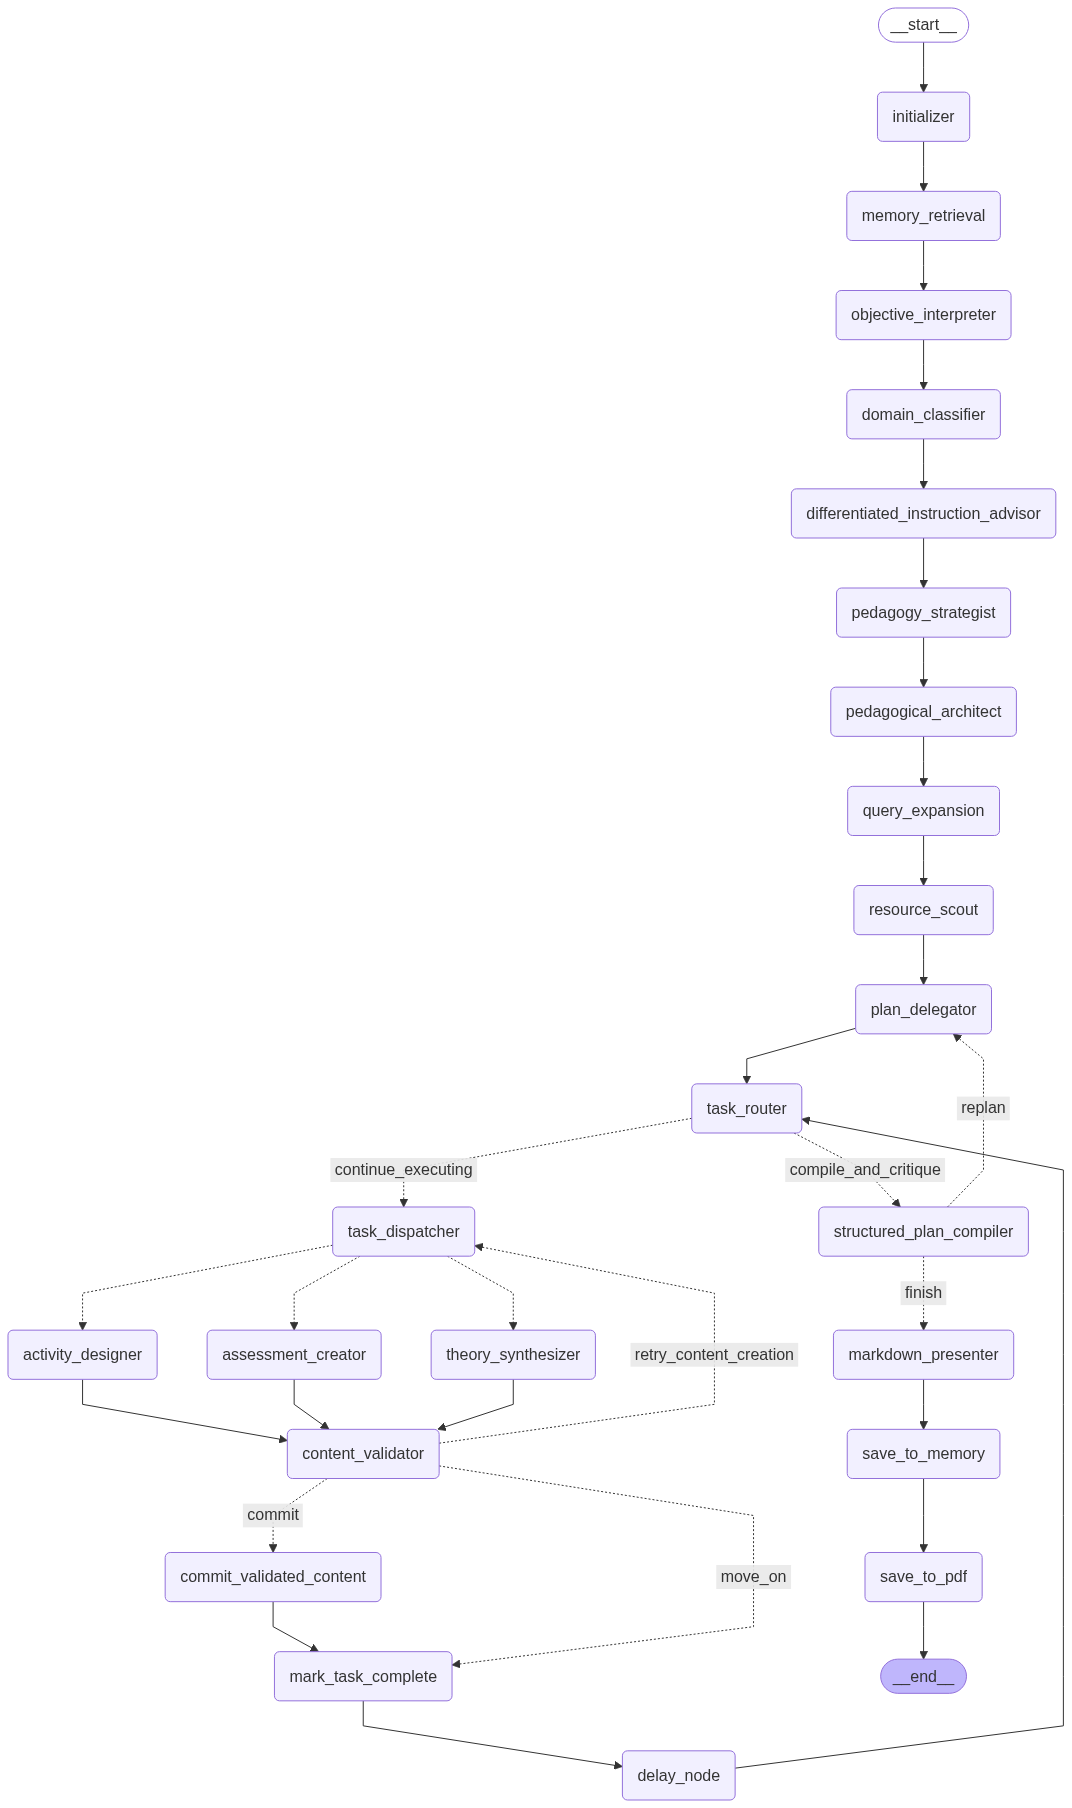

In [36]:
# ==============================================================================
# CELL 4.4: HIỂN THỊ SƠ ĐỒ GRAPH 
# ==============================================================================
try:
    # Lệnh này sẽ vẽ một sơ đồ của workflow, rất hữu ích để gỡ lỗi
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Lỗi vẽ biểu đồ: {e}. Đây là lỗi không nghiêm trọng, bạn vẫn có thể chạy quy trình.")

## PHẦN 5

In [37]:
# ==============================================================================
# CELL 5.1: ĐỊNH NGHĨA HÀM CHẠY QUY TRÌNH 
# ==============================================================================
async def run_architect(user_request: str):
    if 'llm' not in globals() or llm is None:
        print_warning("LLM chưa được khởi tạo.")
        return
    if 'vector_store' not in globals() or vector_store is None:
        print_warning("Kho tri thức chưa được tải.")
        return
    if 'app' not in globals():
        print_warning("Graph 'app' chưa được biên dịch.")
        return

    initial_state = {"messages": [HumanMessage(content=user_request)]}
    console.print(f"\n[bold magenta]🚀 BẮT ĐẦU QUY TRÌNH V12.0 (HOÀN THIỆN) VỚI YÊU CẦU:[/bold magenta]\n> {user_request}")
    config = {"recursion_limit": 150} 
    
    final_markdown_plan = None
    final_structured_plan = None
    
    try:
        async for event in app.astream(initial_state, config=config):
            for node_name, node_output in event.items():
                console.print(f"\n[bold yellow]------- Hoàn thành bước: {node_name} -------[/bold yellow]")
                if node_name == "markdown_presenter":
                    final_markdown_plan = node_output.get("final_markdown_plan")
                    final_structured_plan = node_output.get("final_structured_plan")

        console.print("\n[bold magenta]🏁 KẾT THÚC QUY TRÌNH.[/bold magenta]")
        
        if final_markdown_plan:
            console.print("\n[bold green]📝 GIÁO ÁN HOÀN CHỈNH (v12.0)[/bold green]")
            console.print(Markdown(final_markdown_plan))
            
            if VERBOSE_MODE and final_structured_plan:
                print_result(final_structured_plan, "Output JSON có cấu trúc")
        else:
            print_warning("Không tạo được giáo án cuối cùng. Vui lòng kiểm tra log để gỡ lỗi.")
            
    except Exception as e:
        print_warning(f"Đã xảy ra lỗi nghiêm trọng trong quá trình chạy graph: {e}")
        import traceback
        traceback.print_exc()

print("✅ Hàm `run_architect` (v12.0) đã sẵn sàng để sử dụng.")

✅ Hàm `run_architect` (v12.0) đã sẵn sàng để sử dụng.


In [38]:
# ==============================================================================
# CELL 5.2: KÍCH HOẠT CHẠY THỬ NGHIỆM
# ==============================================================================
# Yêu cầu để kiểm tra
architect_request = "Soạn giúp tôi giáo án bài 'PHƯƠNG TRÌNH MẶT CẦU' cho học sinh lớp 12 trong 90 phút. Đây là một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao."
VERBOSE_MODE = True 

# Chạy quy trình đã được cải cách
await run_architect(architect_request)

🚀 BẮT ĐẦU QUY TRÌNH V12.0 (HOÀN THIỆN) VỚI YÊU CẦU:
> Soạn giúp tôi giáo án bài 'PHƯƠNG TRÌNH MẶT CẦU' cho học sinh lớp 12 trong 90 phút. Đây là một lớp học khá yếu, 
các em thường mất tập trung và cần các hoạt động có tính tương tác cao.

> `Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...

------- Hoàn thành bước: initializer -------

> `Agent: Memory Retrieval` (v9.4) đang tìm kiếm trong trí nhớ...

✔️ Tìm thấy ví dụ tương đồng trong trí nhớ:

"Soạn giúp tôi giáo án bài 'PHƯƠNG TRÌNH MẶT CẦU' cho học sinh lớp 12 trong 90 phút. Đây là một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao."

------- Hoàn thành bước: memory_retrieval -------

> `Agent: Objective Interpreter` (v7.5) đang phân tích mục tiêu...

✔️ Mục tiêu & Ràng buộc đã phân tích:

{
│   'action_verb': 'Soạn',
│   'bloom_level': 2,
│   'topic': 'Phương trình mặt cầu',
│   'grade_level': 'Lớp 12',
│   'constraints': {
│   │   'duration_minutes': 90
│   }
}

------- Hoàn thành bước: objective_interpreter -------

> `Agent: Domain Classifier` (v7.5) đang xác định lĩnh vực chuyên môn...

✔️ Lĩnh vực chuyên môn được xác định:

'Toán học'

------- Hoàn thành bước: domain_classifier -------

> `Agent: Differentiated Instruction Advisor` (v9.1) đang phân tích và đề xuất chiến lược phân hóa...

✔️ Hồ sơ lớp học và Chiến lược Phân hóa:

{
│   'learning_pace': 'chậm',
│   'engagement_style': 'thụ động',
│   'special_notes': 'Lớp học khá yếu, học sinh thường mất tập trung và cần các hoạt động có tính tương tác cao để duy trì sự chú ý và hứng thú học tập.',
│   'differentiation_strategy': {
│   │   'for_struggling_students': 'Chia nhỏ kiến thức thành các phần rất nhỏ, sử dụng nhiều ví dụ minh họa trực quan và vật thật (nếu có), cung cấp phiếu bài tập có gợi ý công thức và các bước giải mẫu, thường xuyên kiểm tra nhanh sự hiểu bài và củng cố kiến thức ngay lập tức. Tổ chức các hoạt động nhóm nhỏ để học sinh yếu có cơ hội được hỗ trợ từ bạn bè và giáo viên.',
│   │   'for_advanced_students': "Giao các bài tập mở rộng có tính ứng dụng thực tế hoặc yêu cầu tư duy phản biện (ví dụ: 'Xác định phương trình mặt cầu trong không gian Oxyz khi biết các điều kiện phức tạp hơn'), khuyến khích các em tự tìm tòi các dạng bài nâng cao hoặc giải thích bài toán cho các bạn trong nhóm. Chuẩn bị các câu hỏi 'Tại sao?' và 'Nếu... thì sao?' để kích thích tư duy sâu hơn."
│   }
}

------- Hoàn thành bước: differentiated_instruction_advisor -------

> `Agent: Pedagogy Strategist` (v7.5) đang xây dựng chiến lược sư phạm chi tiết...

✔️ Chiến lược sư phạm chi tiết:

{
│   'name': 'Dạy học hợp tác (Cooperative Learning)',
│   'rationale': 'Phương pháp Dạy học hợp tác là lựa chọn tối ưu cho lớp học có tốc độ học chậm, học sinh thụ động và dễ mất tập trung. Nó khuyến khích sự tương tác cao, giúp học sinh yếu nhận được sự hỗ trợ trực tiếp từ bạn bè và giáo viên, đồng thời tạo cơ hội cho học sinh khá giỏi củng cố kiến thức bằng cách giải thích cho người khác. Việc làm việc nhóm giúp duy trì sự chú ý và hứng thú học tập, giảm bớt áp lực cá nhân, đồng thời rèn luyện kỹ năng giải quyết vấn đề và giao tiếp. Các hoạt động nhóm nhỏ cũng tạo điều kiện thuận lợi để giáo viên thực hiện chiến lược phân hóa, cung cấp sự hỗ trợ kịp thời cho học sinh yếu và thử thách học sinh giỏi với các bài tập mở rộng.',
│   'key_actions': [
│   │   'Tổ chức nhóm học tập: Chia lớp thành các nhóm nhỏ (3-4 học sinh), đa dạng về năng lực (có cả học sinh khá, giỏi và yếu) để tối ưu hóa sự hỗ trợ lẫn nhau.',
│   │   'Giao nhiệm vụ học tập cụ thể: Cung cấp các phiếu bài tập được thiết kế theo từng bước nhỏ, từ nhận diện các yếu tố của mặt cầu đến viết phương trình mặt cầu trong các trường hợp cơ bản và nâng cao dần. Các phiếu này có thể bao gồm gợi ý công thức hoặc ví dụ mẫu.',
│   │   'Học sinh làm việc nhóm: Các thành viên trong nhóm cùng nhau thảo luận, phân công nhiệm vụ, tìm tòi cách giải quyết các bài toán về phương trình mặt cầu và hỗ trợ lẫn nhau để hoàn thành nhiệm vụ.',
│   │   'Giáo viên quan sát và hỗ trợ: Giáo viên di chuyển giữa các nhóm, lắng nghe các cuộc thảo luận, kịp thời giải đáp thắc mắc, đưa ra gợi ý khi cần thiết và kiểm tra nhanh sự hiểu bài của từng nhóm.',
│   │   'Trình bày và chia sẻ kết quả: Đại diện các nhóm trình bày sản phẩm hoặc lời giải của mình trước lớp. Giáo viên khuyến khích các nhóm khác đặt câu hỏi hoặc bổ sung ý kiến.',
│   │   'Thảo luận chung và củng cố: Cả lớp cùng thảo luận về các phương án giải quyết, giáo viên chốt lại kiến thức trọng tâm, sửa chữa các lỗi sai phổ biến và tổng kết các dạng bài tập cơ bản về phương trình mặt cầu.'
│   ]
}

------- Hoàn thành bước: pedagogy_strategist -------

> `Agent: Pedagogical Architect` (v9.4) đang thiết kế kịch bản buổi học...

✔️ Bản thiết kế Sư phạm đã được tạo:

[
│   'Khởi động và Khám phá Khái niệm Mặt cầu: Giáo viên sử dụng các vật thể thực tế (quả bóng, quả địa cầu, đĩa CD, vòng tròn) để học sinh quan sát, cầm nắm và thảo luận nhóm nhỏ (3-4 học sinh) về sự khác biệt giữa mặt cầu và hình tròn. Giáo viên đặt câu hỏi gợi mở, khuyến khích học sinh chia sẻ nhận định và tổng kết khái niệm cơ bản về mặt cầu.',
│   'Xây dựng và Thực hành Phương trình Mặt cầu Dạng Chính tắc: Giáo viên giới thiệu công thức phương trình mặt cầu dạng chính tắc (tâm I(a,b,c), bán kính R). Học sinh làm việc theo nhóm nhỏ để thực hành viết phương trình mặt cầu khi biết tâm và bán kính, hoặc xác định tâm và bán kính từ phương trình cho trước. Giáo viên đi lại quan sát, hỗ trợ các nhóm yếu bằng cách cung cấp gợi ý công thức và các bước giải mẫu, đồng thời khuyến khích nhóm khá/giỏi giải thích cho bạn.',
│   'Khám phá và Luyện tập Phương trình Mặt cầu Dạng Khai triển: Giáo viên hướng dẫn cách chuyển đổi từ phương trình mặt cầu dạng khai triển sang dạng chính tắc và ngược lại, cũng như cách xác định tâm, bán kính và điều kiện để một phương trình là phương trình mặt cầu. Học sinh tiếp tục làm việc nhóm với các bài tập có độ khó tăng dần, bao gồm cả việc tìm điều kiện của tham số để phương trình là mặt cầu. Giáo viên tập trung hỗ trợ các nhóm gặp khó khăn trong việc biến đổi đại số và khuyến khích học sinh giỏi thử sức với các bài toán có tham số.',
│   'Vận dụng và Giải quyết Bài toán Tổng hợp: Giáo viên đưa ra một bài toán tổng hợp có tính ứng dụng thực tế hoặc yêu cầu tư duy phản biện (ví dụ: tìm phương trình mặt cầu đi qua 4 điểm, hoặc mặt cầu tiếp xúc với mặt phẳng). Học sinh làm việc theo nhóm để phân tích đề bài, lập kế hoạch giải và trình bày lời giải. Giáo viên chỉ đóng vai trò gợi ý, không giải trực tiếp, khuyến khích các nhóm tự tìm tòi và thảo luận sâu. Các nhóm khá/giỏi có thể được giao thêm các bài toán mở rộng phức tạp hơn.',
│   'Tổng kết Kiến thức và Định hướng Mở rộng: Giáo viên cùng học sinh tổng kết các kiến thức trọng tâm đã học về phương trình mặt cầu (khái niệm, dạng chính tắc, dạng khai triển, cách xác định tâm/bán kính, điều kiện). Giáo viên đặt câu hỏi mở để học sinh liên hệ kiến thức với thực tế hoặc các chủ đề khác, đồng thời định hướng các nội dung mở rộng hoặc bài tập về nhà. Khuyến khích học sinh đặt câu hỏi về những điểm còn thắc mắc hoặc muốn tìm hiểu sâu hơn.'
]

------- Hoàn thành bước: pedagogical_architect -------

> `Agent: Query Expansion` (v7.5) đang phân tích yêu cầu...

✔️ Các truy vấn tìm kiếm đã được mở rộng:

[
│   'Lý thuyết phương trình mặt cầu lớp 12',
│   'Bài tập phương trình mặt cầu toán 12 có lời giải',
│   'Công thức phương trình mặt cầu lớp 12 đầy đủ',
│   'Các dạng bài tập phương trình mặt cầu lớp 12',
│   'Chuyên đề phương trình mặt cầu ôn thi THPT Quốc gia lớp 12',
│   'Trắc nghiệm phương trình mặt cầu lớp 12 có đáp án',
│   'Cách viết phương trình mặt cầu lớp 12',
│   'Vị trí tương đối giữa mặt phẳng và mặt cầu lớp 12',
│   'Phương trình mặt cầu đi qua 4 điểm lớp 12',
│   'Tổng hợp kiến thức phương trình mặt cầu lớp 12'
]

------- Hoàn thành bước: query_expansion -------

> `Agent: Resource Scout` (v8.1 - Sửa lỗi) đang tìm kiếm và sàng lọc...

> Tìm thấy 50 tài liệu, sàng lọc còn 8 đoạn văn bản độc nhất.

✔️ Tài liệu RAG cuối cùng:

{
│   'source': 'Sách giáo khoa (từ RAG - đã sàng lọc)',
│   'summary': 'Chào các em học sinh thân mến!\n\nHôm nay, thầy trò chúng ta cùng nhau tóm tắt lại những kiến thức cốt lõi nhất về **Phương trình mặt cầu** nhé. Đây là một chủ đề rất quan trọng trong hình học không gian Oxyz đấy!\n\nĐể nắm vững phương trình mặt cầu, các em cần nhớ những điểm chính sau:\n\n*   **1. Các dạng phương trình mặt cầu cơ bản:**\n    *   **Dạng chính tắc:** Đây là dạng dễ nhận biết nhất, có dạng:\n        **(x – a)² + (y – b)² + (z – c)² = R²**\n        Từ phương trình này, chúng ta dễ dàng xác định được ngay:\n        *   **Tâm I(a; b; c)** của mặt cầu.\n        *   **Bán kính R** của mặt cầu (là căn bậc hai của vế phải).\n        *   *Ví dụ:* Với phương trình (x – 1/2)² + (y+1)² + z² = 9, tâm là I(1/2; -1; 0) và bán kính R = 3.\n    *   **Dạng tổng quát:** Phương trình mặt cầu còn có thể xuất hiện dưới dạng khai triển:\n        **x² + y² + z² + Ax + By + Cz + D = 0**\n        Từ dạng này, chúng ta **có thể xác định được tâm và bán kính** của mặt cầu bằng cách biến đổi hoặc áp dụng công thức.\n        *   *Ví dụ:* x² + y² + z² + 4x – 5y + 6z + 25/4 = 0 là một phương trình mặt cầu dạng tổng quát.\n\n*   **2. Điều kiện để một phương trình là phương trình mặt cầu:**\n    *   Không phải phương trình nào có dạng tổng quát cũng là mặt cầu đâu nhé! Một phương trình dạng x² + y² + z² + Ax + By + Cz + D = 0 chỉ là phương trình mặt cầu khi **bán kính R tính được phải là một số dương (R > 0)**. Nếu R² ≤ 0 thì đó không phải là phương trình mặt cầu.\n\n*   **3. Cách viết phương trình mặt cầu:**\n    *   Để viết phương trình mặt cầu, chúng ta cần biết **tâm I(a; b; c)** và **bán kính R**. Khi có đủ hai yếu tố này, chúng ta chỉ việc thay vào dạng chính tắc là xong!\n    *   **Đặc biệt:** Bán kính R đôi khi không cho trực tiếp mà được xác định thông qua **khoảng cách từ tâm I đến một mặt phẳng (P)**.\n\n*   **4. Công thức tính khoảng cách từ một điểm đến một mặt phẳng:**\n    *   Đây là một công cụ rất hữu ích khi làm việc với mặt cầu. Khoảng cách từ điểm M(x₀; y₀; z₀) đến mặt phẳng (P): Ax + By + Cz + D = 0 được tính bằng công thức:\n        **d(M, (P)) = |Ax₀ + By₀ + Cz₀ + D| / √(A² + B² + C²)**\n    *   *Ví dụ:* Khoảng cách từ M(1;2;–1) đến mặt phẳng (P): x + 2y – 2z + 5 = 0 là d(M, (P)) = |1 + 2⋅2 – 2⋅(–1) + 5| / √(1²+2²+(–2)²) = 4.\n\n*   **5. Kiểm tra vị trí của một điểm so với mặt cầu:**\n    *   Để biết một điểm M có thuộc "vùng phủ sóng" của một thiết bị (tức là nằm trong hoặc trên mặt cầu) hay không, chúng ta cần **tính khoảng cách từ điểm M đó đến tâm I của mặt cầu**, sau đó **so sánh với bán kính R**.\n\n*   **6. Ứng dụng của phương trình mặt cầu trong thực tiễn:**\n    *   Tài liệu có đề cập đến "MỘT SỐ ỨNG DỤNG CỦA PHƯƠNG TRÌNH MẶT CẦU TRONG THỰC TIỄN" nhưng **không cung cấp thông tin chi tiết về các ứng dụng này**.\n\nCác em nhớ ôn tập kỹ những điểm này để làm bài tập thật tốt nhé! Chúc các em học tốt!'
}

------- Hoàn thành bước: resource_scout -------

> `Agent: Headmaster Delegator` (v13.1 - Giao việc Thông minh) đang chỉ đạo...

✔️ Đã tạo 5 nhiệm vụ với chỉ dẫn chi tiết:

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khám phá Khái niệm Mặt cầu',
│   │   'task_description': 'Tổ chức hoạt động khởi động bằng vật thể thực tế và thảo luận nhóm để học sinh phân biệt mặt cầu và hình tròn, từ đó tổng kết khái niệm cơ bản về mặt cầu.',
│   │   'estimated_duration': 15,
│   │   'guidance': 'Hướng dẫn học sinh khám phá và định nghĩa mặt cầu.',
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Xây dựng và Thực hành Phương trình Mặt cầu Dạng Chính tắc',
│   │   'task_description': 'Giới thiệu công thức phương trình mặt cầu dạng chính tắc. Tổ chức hoạt động nhóm để học sinh thực hành viết phương trình từ tâm/bán kính và ngược lại, có sự hỗ trợ và khuyến khích từ giáo viên.',
│   │   'estimated_duration': 20,
│   │   'guidance': 'Hướng dẫn học sinh xây dựng và thực hành phương trình mặt cầu dạng chính tắc.',
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Khám phá và Luyện tập Phương trình Mặt cầu Dạng Khai triển',
│   │   'task_description': 'Hướng dẫn chuyển đổi giữa dạng khai triển và chính tắc, xác định tâm/bán kính và điều kiện của phương trình mặt cầu. Tổ chức luyện tập nhóm với bài tập độ khó tăng dần, bao gồm bài toán tham số.',
│   │   'estimated_duration': 25,
│   │   'guidance': 'Hướng dẫn học sinh khám phá và luyện tập phương trình mặt cầu dạng khai triển.',
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Vận dụng Giải quyết Bài toán Tổng hợp',
│   │   'task_description': 'Đưa ra bài toán tổng hợp (ứng dụng thực tế hoặc tư duy phản biện) để học sinh làm việc nhóm, phân tích, lập kế hoạch và trình bày lời giải. Giáo viên chỉ gợi ý, khuyến khích tự tìm tòi.',
│   │   'estimated_duration': 20,
│   │   'guidance': 'Hướng dẫn học sinh vận dụng kiến thức giải quyết bài toán tổng hợp.',
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Tổng kết và Định hướng Mở rộng',
│   │   'task_description': 'Cùng học sinh tổng kết kiến thức trọng tâm về phương trình mặt cầu. Đặt câu hỏi mở để liên hệ thực tế, định hướng nội dung mở rộng và bài tập về nhà, khuyến khích học sinh đặt câu hỏi.',
│   │   'estimated_duration': 10,
│   │   'guidance': 'Hướng dẫn học sinh tổng kết kiến thức và định hướng học tập tiếp theo.',
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khám phá Khái niệm Mặt cầu' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v13.1 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá Khái niệm Mặt cầu',
│   'duration_minutes': 15,
│   'teacher_actions': [
│   │   'Giới thiệu mục tiêu bài học: Khám phá và định nghĩa mặt cầu.',
│   │   'Phát cho mỗi nhóm một vật thể có dạng hình cầu (ví dụ: quả bóng, quả địa cầu nhỏ) hoặc yêu cầu học sinh quan sát các vật thể hình cầu trong lớp.',
│   │   "Đặt câu hỏi gợi mở: 'Các em hãy quan sát vật thể này và cho biết nó có những đặc điểm gì nổi bật? Các điểm trên bề mặt vật thể này có gì đặc biệt so với một điểm ở tâm?'",
│   │   'Quan sát các nhóm thảo luận, lắng nghe các ý kiến và hỗ trợ khi cần thiết, đảm bảo tất cả học sinh đều tham gia.',
│   │   'Yêu cầu đại diện một vài nhóm trình bày kết quả quan sát và định nghĩa sơ bộ của nhóm về mặt cầu.',
│   │   'Tổng hợp các ý kiến, chốt lại các đặc điểm quan trọng và đưa ra định nghĩa chuẩn về mặt cầu (tập hợp các điểm cách đều một điểm cố định).'
│   ],
│   'extension_component': 'Học sinh có thể vẽ phác thảo một mặt cầu và đánh dấu tâm, bán kính. Hoặc tìm thêm các ví dụ về mặt cầu trong đời sống và giải thích tại sao chúng lại có dạng mặt cầu.',
│   'solution_guide': 'Các câu hỏi gợi mở: 1. Các điểm trên bề mặt vật thể này có gì chung? 2. Có một điểm nào đó mà tất cả các điểm trên bề mặt đều cách đều không? 3. Khoảng cách đó gọi là gì? 4. Vậy mặt cầu là gì?',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp các vật thể hình cầu có kích thước lớn, dễ quan sát. Gợi ý cụ thể hơn bằng cách đặt câu hỏi trực tiếp về tâm và khoảng cách. Có thể cho học sinh dùng thước dây để đo thử khoảng cách từ tâm đến các điểm trên bề mặt.',
│   │   'for_advanced_students': 'Yêu cầu học sinh suy nghĩ về sự khác biệt giữa mặt cầu và hình cầu. Hoặc đặt câu hỏi về công thức tính diện tích mặt cầu (nếu đã học) hoặc các ứng dụng phức tạp hơn của mặt cầu trong khoa học.'
│   },
│   'question_or_description': 'Học sinh làm việc theo nhóm (2-3 người). Mỗi nhóm được cung cấp một vật thể hình cầu hoặc được yêu cầu quan sát các vật thể hình cầu xung quanh. Các nhóm thảo luận để xác định các đặc điểm chung của vật thể, đặc biệt là mối quan hệ giữa các điểm trên bề mặt và một điểm cố định (tâm). Từ đó, các nhóm cố gắng đưa ra một định nghĩa sơ bộ về mặt cầu.',
│   'content_type': 'Thảo luận nhóm và Khám phá'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Easy-Going Critic` (v13.1) đang phân tích...

> ✔️ CRITIC (Lần 1): Nội dung được duyệt! (Góp ý: Hoạt động này rất tốt và có tính khám phá cao. Tuy nhiên, với 15 
phút, việc thực hiện đầy đủ các bước từ thảo luận nhóm, đại diện trình bày đến tổng kết và đưa ra định nghĩa chuẩn 
có thể hơi gấp. Giáo viên cần quản lý thời gian rất chặt chẽ, có thể giới hạn số nhóm trình bày hoặc rút gọn phần 
tổng kết nếu học sinh đã nắm được ý chính để đảm bảo kịp tiến độ.)

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Xây dựng và Thực hành Phương trình Mặt cầu Dạng Chính tắc' (ID: 1)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v13.1 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Xây dựng và Thực hành Phương trình Mặt cầu Dạng Chính tắc',
│   'duration_minutes': 20,
│   'teacher_actions': [
│   │   'Giới thiệu mục tiêu bài học và tầm quan trọng của phương trình mặt cầu trong không gian (2 phút).',
│   │   'Nhắc lại định nghĩa mặt cầu và công thức tính khoảng cách giữa hai điểm trong không gian (3 phút).',
│   │   'Hướng dẫn học sinh tự xây dựng phương trình mặt cầu dạng chính tắc từ định nghĩa (5 phút).',
│   │   'Cung cấp 2 bài tập vận dụng cơ bản (1 bài viết phương trình khi biết tâm/bán kính, 1 bài tìm tâm/bán kính từ phương trình) và yêu cầu học sinh làm cá nhân hoặc theo cặp (8 phút).',
│   │   'Đi lại các nhóm/cá nhân để quan sát, hỗ trợ, giải đáp thắc mắc và kiểm tra nhanh kết quả.',
│   │   'Tổng kết nhanh các kiến thức trọng tâm và các lỗi thường gặp (2 phút cuối).'
│   ],
│   'extension_component': 'Viết phương trình mặt cầu có tâm I(1,2,3) và đi qua điểm A(4,5,6).',
│   'solution_guide': 'Công thức phương trình mặt cầu tâm I(a,b,c), bán kính R là: (x-a)^2 + (y-b)^2 + (z-c)^2 = R^2. Hướng dẫn giải chi tiết 2 bài tập cơ bản trong phần cốt lõi, nhấn mạnh cách xác định tâm và bán kính.',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp sẵn công thức phương trình mặt cầu và yêu cầu học sinh chỉ cần thay số vào để giải các bài tập đơn giản (ví dụ: tâm là gốc tọa độ, bán kính là số nguyên nhỏ).',
│   │   'for_advanced_students': 'Yêu cầu học sinh chứng minh công thức phương trình mặt cầu từ định nghĩa hoặc giải bài tập mở rộng: Viết phương trình mặt cầu có tâm I(1,2,3) và đi qua điểm A(4,5,6).'
│   },
│   'question_or_description': 'Học sinh tự xây dựng công thức phương trình mặt cầu dạng chính tắc dựa trên định nghĩa (tâm I(a,b,c), bán kính R). Vận dụng công thức để viết phương trình mặt cầu khi biết tâm và bán kính, và xác định tâm, bán kính từ một phương trình cho trước thông qua 2 bài tập cơ bản.',
│   'content_type': 'Thực hành có hướng dẫn'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Easy-Going Critic` (v13.1) đang phân tích...

> ✔️ CRITIC (Lần 1): Nội dung được duyệt! (Góp ý: Hoạt động này được thiết kế rất tốt, bao gồm đầy đủ các bước từ 
giới thiệu, ôn tập, xây dựng kiến thức mới đến vận dụng và tổng kết, với thời lượng phân bổ hợp lý cho từng phần 
chính. Tuy nhiên, việc triển khai đồng thời phần mở rộng (extension_component) và phân hóa cho học sinh khá giỏi 
trong khuôn khổ 20 phút có thể khá thách thức. Giáo viên cần quản lý thời gian rất hiệu quả, có thể coi phần mở 
rộng là bài tập thêm cho học sinh hoàn thành nhanh hoặc giao về nhà để đảm bảo các mục tiêu cốt lõi được đạt được 
trong giờ.)

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khám phá và Luyện tập Phương trình Mặt cầu Dạng Khai triển' (ID: 2)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v13.1 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá và Luyện tập Phương trình Mặt cầu Dạng Khai triển',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Giới thiệu mục tiêu hoạt động và thời gian thực hiện (25 phút).',
│   │   'Gợi ý học sinh nhớ lại phương trình mặt cầu dạng chính tắc và cách khai triển biểu thức bình phương.',
│   │   'Phát phiếu học tập hoặc trình chiếu ví dụ khai triển mẫu để học sinh tham khảo.',
│   │   'Quan sát, đi lại hỗ trợ các nhóm/cá nhân gặp khó khăn trong quá trình khai triển và rút ra công thức.',
│   │   'Đặt câu hỏi gợi mở để học sinh tự tìm ra mối liên hệ giữa các hệ số và tâm, bán kính.',
│   │   'Yêu cầu một vài học sinh/nhóm trình bày kết quả khai triển và công thức tổng quát.',
│   │   'Chốt kiến thức về phương trình mặt cầu dạng khai triển, công thức tính tâm và bán kính, điều kiện để một phương trình là mặt cầu.',
│   │   'Chữa nhanh 1-2 bài tập vận dụng cơ bản.',
│   │   'Giao bài tập về nhà hoặc bài tập mở rộng (nếu còn thời gian).'
│   ],
│   'extension_component': 'Học sinh làm thêm các bài tập nâng cao: 1. Tìm điều kiện của tham số để một phương trình bậc hai ba ẩn là phương trình mặt cầu. 2. Viết phương trình mặt cầu dạng khai triển khi biết các điều kiện phức tạp hơn (ví dụ: đi qua 4 điểm, có tâm nằm trên một mặt phẳng...).',
│   'solution_guide': '1. Phương trình mặt cầu dạng chính tắc: (x-a)^2 + (y-b)^2 + (z-c)^2 = R^2. 2. Khai triển: x^2 - 2ax + a^2 + y^2 - 2by + b^2 + z^2 - 2cz + c^2 = R^2. 3. Dạng khai triển tổng quát: x^2 + y^2 + z^2 + 2Ax + 2By + 2Cz + D = 0, với A = -a, B = -b, C = -c, D = a^2 + b^2 + c^2 - R^2. 4. Tâm I(-A; -B; -C). Bán kính R = sqrt(A^2 + B^2 + C^2 - D). 5. Điều kiện để là mặt cầu: A^2 + B^2 + C^2 - D > 0.',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp sẵn một ví dụ khai triển từng bước hoặc công thức khai triển (a+b)^2. Hướng dẫn cụ thể cách nhóm các hạng tử để nhận diện hệ số A, B, C, D. Có thể chỉ yêu cầu làm bài tập xác định tâm và bán kính từ phương trình cho sẵn.',
│   │   'for_advanced_students': 'Yêu cầu chứng minh điều kiện để phương trình x^2 + y^2 + z^2 + 2Ax + 2By + 2Cz + D = 0 là phương trình mặt cầu. Hoặc yêu cầu tìm điều kiện của tham số m để một phương trình cho trước là phương trình mặt cầu.'
│   },
│   'question_or_description': 'Học sinh làm việc cá nhân/nhóm nhỏ để: 1. Nhắc lại phương trình mặt cầu dạng chính tắc. 2. Khai triển một phương trình mặt cầu dạng chính tắc cụ thể (ví dụ: (x-1)^2 + (y+2)^2 + (z-3)^2 = 25) để thu được dạng khai triển. 3. Từ kết quả khai triển, nhận diện các hệ số và rút ra công thức tổng quát của phương trình mặt cầu dạng khai triển: x^2 + y^2 + z^2 + 2Ax + 2By + 2Cz + D = 0. 4. Xác định mối liên hệ giữa tâm I(A; B; C) và bán kính R với các hệ số A, B, C, D. 5. Thực hành 1-2 bài tập cơ bản: a) Cho phương trình dạng khai triển, xác định tâm và bán kính. b) Cho tâm và bán kính, viết phương trình dạng khai triển.',
│   'content_type': 'Hoạt động khám phá và luyện tập'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Easy-Going Critic` (v13.1) đang phân tích...

> ✔️ CRITIC (Lần 1): Nội dung được duyệt! (Góp ý: Hoạt động này được thiết kế rất tốt để học sinh tự khám phá và 
luyện tập. Tuy nhiên, với 25 phút, nội dung khá nhiều, đặc biệt là phần học sinh tự khai triển, rút ra công thức 
tổng quát và mối liên hệ. Giáo viên có thể cần linh hoạt trong việc hướng dẫn, có thể cung cấp sẵn một phần khai 
triển mẫu hoặc rút gọn số lượng bài tập vận dụng để đảm bảo hoàn thành trong thời gian cho phép. Phần mở rộng và 
phân hóa rất hay nhưng có thể chỉ dành cho những học sinh hoàn thành sớm hoặc giao về nhà.)

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Vận dụng Giải quyết Bài toán Tổng hợp' (ID: 3)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v13.1 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Vận dụng Giải quyết Bài toán Tổng hợp',
│   'duration_minutes': 20,
│   'teacher_actions': [
│   │   'Giới thiệu bài toán tổng hợp và mục tiêu của hoạt động.',
│   │   'Phân chia nhóm (nếu có) hoặc hướng dẫn học sinh làm việc cá nhân.',
│   │   'Quan sát, đi lại giữa các nhóm/cá nhân, lắng nghe và hỗ trợ khi cần thiết.',
│   │   'Gợi ý các hướng tiếp cận hoặc công thức liên quan nếu học sinh gặp khó khăn, nhưng không giải hộ.',
│   │   'Yêu cầu một vài nhóm/cá nhân trình bày tóm tắt cách giải và kết quả.',
│   │   'Tổng kết các kiến thức đã được vận dụng và chốt lại các lỗi thường gặp.'
│   ],
│   'extension_component': 'Học sinh hoàn thành sớm có thể tự đặt ra một bài toán tổng hợp khác dựa trên kiến thức đã học và thử thách bạn bè giải quyết, hoặc tìm hiểu sâu hơn về ứng dụng thực tế của dạng bài toán vừa giải.',
│   'solution_guide': "Cung cấp đáp án chi tiết và các bước giải mẫu cho bài toán. Gợi ý các câu hỏi để học sinh tự kiểm tra lại quá trình tư duy, ví dụ: 'Bạn đã sử dụng những kiến thức nào?', 'Có cách giải nào khác không?', 'Kết quả này có hợp lý trong thực tế không?'",
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp các gợi ý cụ thể hơn về các công thức cần sử dụng, chia nhỏ bài toán thành các câu hỏi nhỏ hơn hoặc cho phép sử dụng tài liệu/sách giáo khoa để tra cứu.',
│   │   'for_advanced_students': 'Yêu cầu học sinh tìm thêm một cách giải khác cho bài toán, hoặc tự đặt ra một bài toán tương tự có độ phức tạp cao hơn và giải quyết nó.'
│   },
│   'question_or_description': 'Học sinh làm việc theo nhóm (2-3 người) hoặc cá nhân để giải quyết một bài toán tổng hợp do giáo viên cung cấp. Bài toán được thiết kế để yêu cầu học sinh vận dụng ít nhất 2-3 kiến thức đã học từ các bài trước (ví dụ: bài toán thực tế về tính toán chi phí xây dựng, bài toán vật lý về chuyển động và lực, hoặc bài toán hóa học về nồng độ và phản ứng). Học sinh cần trình bày rõ ràng các bước giải và kết quả.',
│   'content_type': 'Thực hành cá nhân/nhóm'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Easy-Going Critic` (v13.1) đang phân tích...

> ✔️ CRITIC (Lần 1): Nội dung được duyệt! (Góp ý: Hoạt động này được thiết kế rất tốt, bao gồm đầy đủ các yếu tố cần
thiết như phân hóa và mở rộng. Tuy nhiên, với thời lượng 20 phút cho một bài toán tổng hợp yêu cầu học sinh vận 
dụng nhiều kiến thức, làm việc nhóm/cá nhân, trình bày và giáo viên tổng kết, có thể sẽ khá thách thức về mặt thời 
gian. Giáo viên có thể cân nhắc quản lý thời gian thật chặt chẽ, hoặc giảm bớt số lượng nhóm trình bày, hoặc chuẩn 
bị sẵn một số gợi ý để đẩy nhanh tiến độ nếu cần thiết.)

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Tổng kết và Định hướng Mở rộng' (ID: 4)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v13.1 - Tư duy Phản tư) đang tạo nội dung...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Tổng kết và Định hướng Mở rộng',
│   'duration_minutes': 10,
│   'teacher_actions': [
│   │   'Yêu cầu học sinh tổng kết các kiến thức trọng tâm của bài học trong 3 phút.',
│   │   'Lắng nghe và ghi nhận các ý kiến, câu hỏi của học sinh (4 phút).',
│   │   'Tổng hợp nhanh các ý chính và giải đáp các thắc mắc chung (2 phút).',
│   │   'Định hướng các nội dung học tập tiếp theo hoặc gợi ý ứng dụng thực tế của kiến thức vừa học (1 phút).'
│   ],
│   'extension_component': 'Nếu còn thời gian, học sinh có thể lập sơ đồ tư duy (mind map) tóm tắt toàn bộ bài học hoặc đề xuất một câu hỏi nghiên cứu mở rộng liên quan đến chủ đề.',
│   'solution_guide': "Gợi ý các từ khóa chính của bài học để học sinh dễ dàng tổng kết. Các câu hỏi gợi mở: 'Hôm nay chúng ta đã học về điều gì?', 'Kiến thức này có thể áp dụng vào đâu trong cuộc sống?', 'Các em còn thắc mắc gì về bài học không?'",
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp các câu hỏi gợi ý cụ thể hơn (ví dụ: 'Hôm nay chúng ta đã học về khái niệm gì?', 'Các bước thực hiện là gì?') hoặc danh sách từ khóa để các em dễ dàng tổng kết.",
│   │   'for_advanced_students': 'Yêu cầu các em liên hệ kiến thức vừa học với các bài học trước đó hoặc đề xuất một vấn đề thực tế có thể áp dụng kiến thức này để giải quyết.'
│   },
│   'question_or_description': 'Học sinh tự tổng kết 3-5 ý chính của bài học vào vở hoặc phiếu học tập. Sau đó, mỗi học sinh chia sẻ nhanh 1 điều các em thấy thú vị nhất hoặc 1 câu hỏi còn thắc mắc về bài học.',
│   'content_type': 'Tổng kết và Định hướng'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Easy-Going Critic` (v13.1) đang phân tích...

> ✔️ CRITIC (Lần 1): Nội dung được duyệt! (Góp ý: Hoạt động tổng kết này rất toàn diện và có nhiều ý tưởng hay. Tuy
nhiên, với 10 phút, việc thực hiện đầy đủ các bước từ tổng kết cá nhân, chia sẻ, lắng nghe, giải đáp đến định hướng
và cả các phần mở rộng, phân hóa có thể hơi tham vọng. Giáo viên có thể linh hoạt điều chỉnh, ưu tiên các hoạt động
cốt lõi hoặc chọn lọc một số học sinh tiêu biểu để chia sẻ nhằm đảm bảo thời gian.)

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Hết nhiệm vụ, chuyển sang node Compiler.

------- Hoàn thành bước: task_router -------

> `Agent: Structured Plan Compiler` (v12.0) đang tổng hợp giáo án...

> CRITIC LỚN: Kế hoạch hợp lệ! Bắt đầu tổng hợp JSON...

> ROUTER (Compilation): Critic lớn đã hài lòng. Kết thúc quy trình.

------- Hoàn thành bước: structured_plan_compiler -------

> `Node: Pedagogical Editor` (v13.1) đang biên tập và tạo bản trình bày...

> ✔️ Đã biên tập thành công giáo án cuối cùng với lời chuyển mượt mà.

------- Hoàn thành bước: markdown_presenter -------

> 🧠 Đã lưu giáo án thành công vào Trí nhớ Dài hạn.

------- Hoàn thành bước: save_to_memory -------

> Đang chuyển đổi giáo án sang file PDF: 'GiaoAn_Phương_trình_mặt_cầu.pdf'...

✅ Đã lưu giáo án thành công vào file 'GiaoAn_Phương_trình_mặt_cầu.pdf'


------- Hoàn thành bước: save_to_pdf -------

🏁 KẾT THÚC QUY TRÌNH.

📝 GIÁO ÁN HOÀN CHỈNH (v12.0)

Chào các em học sinh thân mến! Hôm nay, với vai trò là một Biên tập viên Sư phạm giàu kinh nghiệm, thầy/cô sẽ trình
bày một giáo án hoàn chỉnh về chủ đề "Phương trình mặt cầu" dành cho các em học sinh lớp 12. Giáo án này được thiết
kế để giúp các em tiếp thu kiến thức một cách chủ động, hứng thú và hiệu quả nhất.                                 

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                           GIÁO ÁN MÔN TOÁN HỌC LỚP 12                                           ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


                                           CHỦ ĐỀ: PHƯƠNG TRÌNH MẶT CẦU                                            

                                                I. THÔNG TIN CHUNG                                                 

 • Chủ Đề: Phương trình mặt cầu                                                                                    
 • Môn Học: Toán học                                                                                               
 • Lớp: Lớp 12                                                                                                     
 • Thời Lượng: 90 phút                                                                                             
 • Phương Pháp Chủ Đạo: Dạy học hợp tác (Cooperative Learning)                                                     
 • Đặc Điểm Lớp Học: Lớp học khá yếu, học sinh thường mất tập trung và cần các hoạt động có tính tương tác cao để  
   duy trì sự chú ý và hứng thú học tập.                                                                           

                                               II. MỤC TIÊU BÀI HỌC                                                

 • Học sinh có thể Soạn kiến thức về Phương trình mặt cầu.                                                         
 • Rèn luyện kỹ năng tư duy logic.                                                                                 
 • Phát triển kỹ năng hợp tác.                                                                                     

                                                   III. CHUẨN BỊ                                                   

 • Giáo Viên: Bảng phụ, máy chiếu, phiếu học tập                                                                   
 • Học Sinh: Sách giáo khoa, vở ghi, dụng cụ học tập                                                               

                                              IV. TIẾN TRÌNH BÀI DẠY                                               

                                 Hoạt động 1: Khám phá Khái niệm Mặt cầu (15 phút)                                 

Nhiệm vụ: Học sinh làm việc theo nhóm (2-3 người). Mỗi nhóm được cung cấp một vật thể hình cầu hoặc được yêu cầu   
quan sát các vật thể hình cầu xung quanh. Các nhóm thảo luận để xác định các đặc điểm chung của vật thể, đặc biệt  
là mối quan hệ giữa các điểm trên bề mặt và một điểm cố định (tâm). Từ đó, các nhóm cố gắng đưa ra một định nghĩa  
sơ bộ về mặt cầu.                                                                                                  

▌ Gợi ý Phân hóa:                                                                                                

▌  • Hỗ trợ (HS yếu): Cung cấp các vật thể hình cầu có kích thước lớn, dễ quan sát. Gợi ý cụ thể hơn bằng cách   
▌    đặt câu hỏi trực tiếp về tâm và khoảng cách. Có thể cho học sinh dùng thước dây để đo thử khoảng cách từ tâm
▌    đến các điểm trên bề mặt.                                                                                   

▌  • Thử thách (HS giỏi): Yêu cầu học sinh suy nghĩ về sự khác biệt giữa mặt cầu và hình cầu. Hoặc đặt câu hỏi về
▌    công thức tính diện tích mặt cầu (nếu đã học) 